# Task 1: Data Understanding and Preparation

## Introduction and Description of the customer_supermarket Dataset

This notebook initially presents an explorative analysis of the "customer_supermarket" dataset describing the transactions describes the transactions that occurred between customers from various parts of the world and an unspecified business entity.

The data is organised in a form of an array, where the dataset attributes (aka features) are organised in columns, and the shoppig sessions (aka instances) in rows. The dataset consists of several data categories describing the purchases performed by the customers (i.e. the id of the virtual basket associated with the purchase, the id and description of the product purchased, the time and date when the transaction took place, etc.).

The dataset includes 471910 data observations.

**Importing libraries**

In [100]:
%matplotlib inline
import math

import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sn

import collections
from collections import defaultdict


**Loading the dataset**

Read the .csv file containing the data. The first line contains the list of attributes. The data is assigned to a Pandas dataframe.

In [101]:
df = pd.read_csv('dataset/customer_supermarket.csv', sep='\t', index_col=0)

## Data Semantics

The pandas function **head()** provides some of the first records of the dataframe. <br>We use it in order to assess the correct loading of the dataset and to provide a example of the records contained within it.

In [102]:
print(df.head()) #print the first records of a df

  BasketID      BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365  01/12/10 08:26  2,55    17850.00  United Kingdom  85123A   
1   536365  01/12/10 08:26  3,39    17850.00  United Kingdom   71053   
2   536365  01/12/10 08:26  2,75    17850.00  United Kingdom  84406B   
3   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029G   
4   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  


### Types of attributes

The pandas function **info()** is used in order to obtain preliminary information on the dataset. <br>It highlights the data type and counts the number of not-null values for each column of the dataset.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


The aforementioned function, other than identifying **471910** as the number of records contained within the dataframe, highlights:

1. the <u>inability of Pandas to recognize</u> the values of *BasketDate* as <u>datetime</u>;
2. the <u>misinterpretation of the values of the attribute *Sale*</u>, being represented as objects and not real numbers, due to the use of the comma as delimiter for decimal values;
3. the presence of <u>missing values</u> within the attributes *CustomerID* and *ProdDescr*;
4. the presence of <u>non numerical values</u> within the attributes *BasketID* and *ProductID*, despite an expectation at a first intuitive level could suggest them to be integer.

Here we present a classification of these attributes by type:

- Categorical Attributes:<br>
    - *BasketID* - ***String***
    - *CustomerID* - ***Float*** right now, then ***String***
    - *CustomerCountry* - ***String***
    - *ProdID* - ***String***
    - *ProdDescr* - ***String***


- Numerical Attributes:<br>
    - *BasketDate* - ***String*** right now, then ***Datetime***
    - *Sale* - ***String*** right now, then ***Float***
    - *Qta*- ***Int***

### Type Conversions

Now we address the first two issues referred above, we want Pandas to:
+ recognize the values from *BasketDate* as datetime and, 
+ recognize the values from *Sale* as floats.

Both of them are fixable by tinkering with the arguments **parse_dates** and **decimal** from the pandas function **read_csv()** as in :

In [104]:
# df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0, decimal = ",",
#                 parse_dates=["BasketDate"])

But, for the sake of this notebook, we will make use of the casting functions provided by Pandas.

#### Converting *BasketDate*
We use the pandas function **to_datetime()** in order to correctly format the values from *BasketDate*.

In [105]:
df['BasketDate'] = pd.to_datetime(df['BasketDate']) # converting 'BasketDate' to datetime

C:\Users\user\AppData\Local\Temp\ipykernel_30388\1320739516.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BasketDate'] = pd.to_datetime(df['BasketDate']) # converting 'BasketDate' to datetime


#### Converting *Sale*
The presence of commas as decimal delimiters is common when working with European data.

We substitute the commas with dots in the *Sale* column and convert it from object to float type using pandas function **astype()**.

In [106]:
df['Sale'] = df['Sale'].str.replace(',', '.') # replacing commas with dots
df['Sale'] = df['Sale'].astype(float) # converting 'Sale' to float type

#### Converting CustomerID

Right now the value from the *CustomerID* attribute are represented as floats. 

However, given the index role of *CustomerID*, its representation as a numeric data is not useful for our analysis. The pandas function **astype()** is, therefore, used to cast the values from said attribute as objects. 

In [107]:
df['CustomerID'] = df['CustomerID'].astype(object) # converting 'CustomerID' to object type

#### Summary on the types of attributes after the conversions

In [108]:
df.dtypes # return the type of each attribute

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

### Relationships among the attributes
We aim to estimate the relationship between the values of the attributes within the dataset.

#### BasketID and BasketDate
We want to verify if each transaction belonging to the same purchase session, identified by a unique value for BasketID, takes place at the same time, i.e. it is associated with a single and unique BasketDate value.

With the following code we verify if some value of BasketID is associated with more than one value of BasketDate.

In [109]:
df.groupby(['BasketID']).BasketDate.nunique().value_counts()

BasketDate
1    24585
2       42
Name: count, dtype: int64

Having ascertained the presence of these conditions, 42 values of BasketID associated with 2 different values of BasketDate, we proceed with the identification of said shopping sessions.

In [110]:
BasketID_Dates = df.groupby(['BasketID']).BasketDate.nunique() # it contains each value of BasketID and the number of BasketDate values it is associated with 
BasketID_mul_Dates = BasketID_Dates[BasketID_Dates > 1] # it contains the BasketID values associated with more than one BasketDate value

The following code displays the difference, expressed in seconds, between the two BasketDate values contained within the first elements of the list above. 

In [111]:
df[df.BasketID.isin(BasketID_mul_Dates.index)].groupby(['BasketID']).BasketDate.unique().head().apply(lambda x: (x[1] - x[0]) / np.timedelta64(1, 's'))

BasketID
536591   60.00
540185   60.00
541596   60.00
541631   60.00
541809   60.00
Name: BasketDate, dtype: float64

We now try to confirm the hypothesis that the tendency observed previously is applicable to all the elements of the list, that is, where multiple BasketDate values are associated with the same BasketID, they tend to be only one minute apart from each other.

In [112]:
df[df.BasketID.isin(BasketID_mul_Dates.index)].groupby(['BasketID']).BasketDate.unique().apply(lambda x: (x[1] - x[0]) / np.timedelta64(1, 'm') <=  1).all()

np.True_

#### BasketID and CustomerID
We want to verify if each transaction belonging to the same purchase session, identified by a unique value for BasketID, is performed by the same customer, i.e. it is associated with a single and unique CustomerID value.

With the following code we verify if some value of BasketID is associated with more than one value of CustomerID.

In [113]:
df.groupby(['BasketID']).CustomerID.nunique().value_counts()

CustomerID
1    22190
0     2437
Name: count, dtype: int64

The code above assess that the presence of missing values for CustomerID within the records associated with 2437 different shopping sessions. 

#### CustomerID and CustomerCountry
We want to verify if each customer, identified by a unique value for CustomerID, performs his purchases from a single country, i.e. it is associated with a single and unique CustomerCountry value.

With the following code we verify if some value of CustomerID is associated with more than one value of CustomerCountry.

In [114]:
df.groupby(['CustomerID']).CustomerCountry.nunique().value_counts()

CustomerCountry
1    4364
2       8
Name: count, dtype: int64

Having ascertained the presence of these conditions, 8 values of CustomerID associated, each, with 2 different values of CustomerCountry, we proceed with the identification of said customers.

In [115]:
CustomerID_Countries = df.groupby(['CustomerID']).CustomerCountry.nunique() # it contains each value of CustomerID and the number of CustomerCountry values it is associated with 
CustomerID_mul_Countries = CustomerID_Countries[CustomerID_Countries > 1] # it contains the CustomerID values associated with more than one CustomerCountry value

The following code displays the CustomerCountry values associated with the customers previously identified and the number of transaction performed from these countries. 

In [116]:
df[df.CustomerID.isin(CustomerID_mul_Countries.index)].groupby(['CustomerID']).CustomerCountry.value_counts()

CustomerID  CustomerCountry
12370.00    Cyprus             159
            Austria              8
12394.00    Belgium             21
            Denmark              6
12417.00    Belgium            175
            Spain               23
12422.00    Australia           21
            Switzerland         18
12429.00    Denmark             76
            Austria             21
12431.00    Australia          186
            Belgium             54
12455.00    Spain               48
            Cyprus              42
12457.00    Switzerland         65
            Cyprus               3
Name: count, dtype: int64

The large difference in values, observed in most of the cases above, suggests each customer's preference for a particular country. 

This observation will be taken into account when calculating the *Country* attribute in the second part of this notebook.

#### ProdID and ProdDescr
We want to verify if each product, identified by a unique value for ProdID, is associated with a single and unique description, identified by a ProdDescr value.

With the following code we verify if some value of ProdID is associated with more than one value of ProdDescr.

In [117]:
df.groupby(['ProdID']).ProdDescr.nunique().value_counts()

ProdDescr
1    3437
2     392
0      64
3      51
4       9
Name: count, dtype: int64

According to the above results, some particular products appear to be associated with several different descriptions. However, given the low importance that ProdDescr has for our analysis, this phenomenon is not further investigated

## Data Statistics

The pandas function **describe()** is used to obtain basic statistical notions regarding the numerical attributes of the dataset.

In [118]:
pd.options.display.float_format = '{:.2f}'.format
df.describe() # this function provides a summary of statistical informations

BasketDate      Sale       Qta
count                         471910 471910.00 471910.00
mean   2011-06-18 05:16:57.050285312      4.03     10.72
min              2010-01-12 08:26:00 -11062.06 -80995.00
25%              2011-03-25 14:00:00      1.25      1.00
50%              2011-07-06 11:50:00      2.08      4.00
75%              2011-10-06 10:26:00      3.75     12.00
max              2011-12-10 17:19:00  38970.00  80995.00
std                              NaN     83.77    231.36

The data provided by the function above highlights:
- the positive distortion of both *Sale* and *Qta*.
- the presence of **negative values** inside both columns.
- the high variance for the attributes, perhaps due to the presence of **outliers**.

### Negative values in *Sale* and *Qta*

Trying to contextualize the presence of records containing such values within the dataset, we briefly check their value for the *ProdDescr* attribute.
A deeper analysis concerning the possibility of outliers does still take place in the section **Assessing and Improving Data Quality**. 

#### Sale

We compute a list of the records with negative values for *Sale*.

In [119]:
# Negative values in Sale
df[df.Sale < 0]

BasketID          BasketDate      Sale CustomerID CustomerCountry  \
299983  A563186 2011-12-08 14:51:00 -11062.06        NaN  United Kingdom   
299984  A563187 2011-12-08 14:52:00 -11062.06        NaN  United Kingdom   

       ProdID        ProdDescr  Qta  
299983      B  Adjust bad debt    1  
299984      B  Adjust bad debt    1

In [120]:
df[df.Sale < 0].ProdDescr

299983    Adjust bad debt
299984    Adjust bad debt
Name: ProdDescr, dtype: object

According to the description associated with both records (*ProdDescr* : "Adjust bad dept"), these transactions could be associated with some kind of refund operation.
    

Anyway, the statistical significance that these two isolated cases have with respect to the analysis of the dataset in question is minimal if compared to the remaining amount of data. <br>Considering these two records as **outliers**, could therefore **improve the total reliability of the remaining tests** conducted on the dataset.

As already mentioned, the further discussion about removing them continues in the section **Assessing and Improving Data Quality**.

#### Qta

We compute a list of the records with negative values for *Qta*.

In [121]:
# Negative values in Qta
df[df.Qta < 0].BasketID.count()

np.int64(9752)

This time the records with a negative value for *Qta* are over 9000 and this amount does guarantee a stronger statistical relevance with respect to the analysis of the dataset.


In [122]:
df[df.Qta < 0].head().ProdDescr

141                            Discount
154     SET OF 3 COLOURED  FLYING DUCKS
235      PLASTERS IN TIN CIRCUS PARADE 
236    PACK OF 12 PINK PAISLEY TISSUES 
237    PACK OF 12 BLUE PAISLEY TISSUES 
Name: ProdDescr, dtype: object

The values of *ProdDescr* associated with these records, however, don't provide any contextualization for the values of *Qta*.
The best hypothesis remains that one of transactions during which the company acquired some asset from the customers instead of selling it to them.

#### Other interesting considerations: high and symmetrical values in Qta

The *min* and *max* values displayed by the **describe()** function for the *Qta* highlight an interesting dynamic concerning couples of records with high and opposite values for *Qta*. 
The list below contains two of such couples.  

In [123]:
df[df.Qta.apply(abs) > 10000]

BasketID          BasketDate  Sale CustomerID CustomerCountry ProdID  \
61619    541431 2011-01-18 10:01:00  1.04   12346.00  United Kingdom  23166   
61624   C541433 2011-01-18 10:17:00  1.04   12346.00  United Kingdom  23166   
502122   578841 2011-11-25 15:57:00  0.00   13256.00  United Kingdom  84826   
540421   581483 2011-09-12 09:15:00  2.08   16446.00  United Kingdom  23843   
540422  C581484 2011-09-12 09:27:00  2.08   16446.00  United Kingdom  23843   

                             ProdDescr    Qta  
61619   MEDIUM CERAMIC TOP STORAGE JAR  74215  
61624   MEDIUM CERAMIC TOP STORAGE JAR -74215  
502122  ASSTD DESIGN 3D PAPER STICKERS  12540  
540421     PAPER CRAFT , LITTLE BIRDIE  80995  
540422     PAPER CRAFT , LITTLE BIRDIE -80995

Within each of these couples, the record with the negative value for Qta displays a BasketID containing the letter 'C'. 
We therefore compute a list of each record displaying a similar BasketID and a negative value for Qta.

In [124]:
df[(df.BasketID.str.contains('C')) & (df.Qta < 0)]

BasketID          BasketDate   Sale CustomerID CustomerCountry  ProdID  \
141     C536379 2010-01-12 09:41:00  27.50   14527.00  United Kingdom       D   
154     C536383 2010-01-12 09:49:00   4.65   15311.00  United Kingdom  35004C   
235     C536391 2010-01-12 10:24:00   1.65   17548.00  United Kingdom   22556   
236     C536391 2010-01-12 10:24:00   0.29   17548.00  United Kingdom   21984   
237     C536391 2010-01-12 10:24:00   0.29   17548.00  United Kingdom   21983   
...         ...                 ...    ...        ...             ...     ...   
540449  C581490 2011-09-12 09:57:00   0.83   14397.00  United Kingdom   23144   
541541  C581499 2011-09-12 10:28:00 224.69   15498.00  United Kingdom       M   
541715  C581568 2011-09-12 11:57:00  10.95   15311.00  United Kingdom   21258   
541716  C581569 2011-09-12 11:58:00   1.25   17315.00  United Kingdom   84978   
541717  C581569 2011-09-12 11:58:00   1.25   17315.00  United Kingdom   20979   

                               ProdDescr  Qta  
141                             Discount   -1  
154      SET OF 3 COLOURED  FLYING DUCKS   -1  
235       PLASTERS IN TIN CIRCUS PARADE   -12  
236     PACK OF 12 PINK PAISLEY TISSUES   -24  
237     PACK OF 12 BLUE PAISLEY TISSUES   -24  
...                                  ...  ...  
540449   ZINC T-LIGHT HOLDER STARS SMALL  -11  
541541                            Manual   -1  
541715        VICTORIAN SEWING BOX LARGE   -5  
541716  HANGING HEART JAR T-LIGHT HOLDER   -1  
541717     36 PENCILS TUBE RED RETROSPOT   -5  

[9084 rows x 8 columns]

We assume the meaning of these couples as some kind of refund activity after a canceled purchase. The presence of another record, with a positive and opposite value of Qta, for each of the components of this list is expected due to this theory.

We aim to drop each of these couples or, in alternative, to sum up the discordant values of Qta within a single record. Said procedure will help to avoid future interferences when computing the number of items, or distinct items, purchased by a customer and will be addressed within the section **Assessing and Improving Data Quality**.    

### Data Distributions

#### BasketID

We calculate the total number of distinct values for the attribute BasketID contained within the records from the dataset.

In [125]:
len(df.BasketID.unique())

24627

#### BasketDate

We analyze the distribution of the BasketDate attribute by grouping up the records from the same week, here expressed by its number (from 1 to 52).  

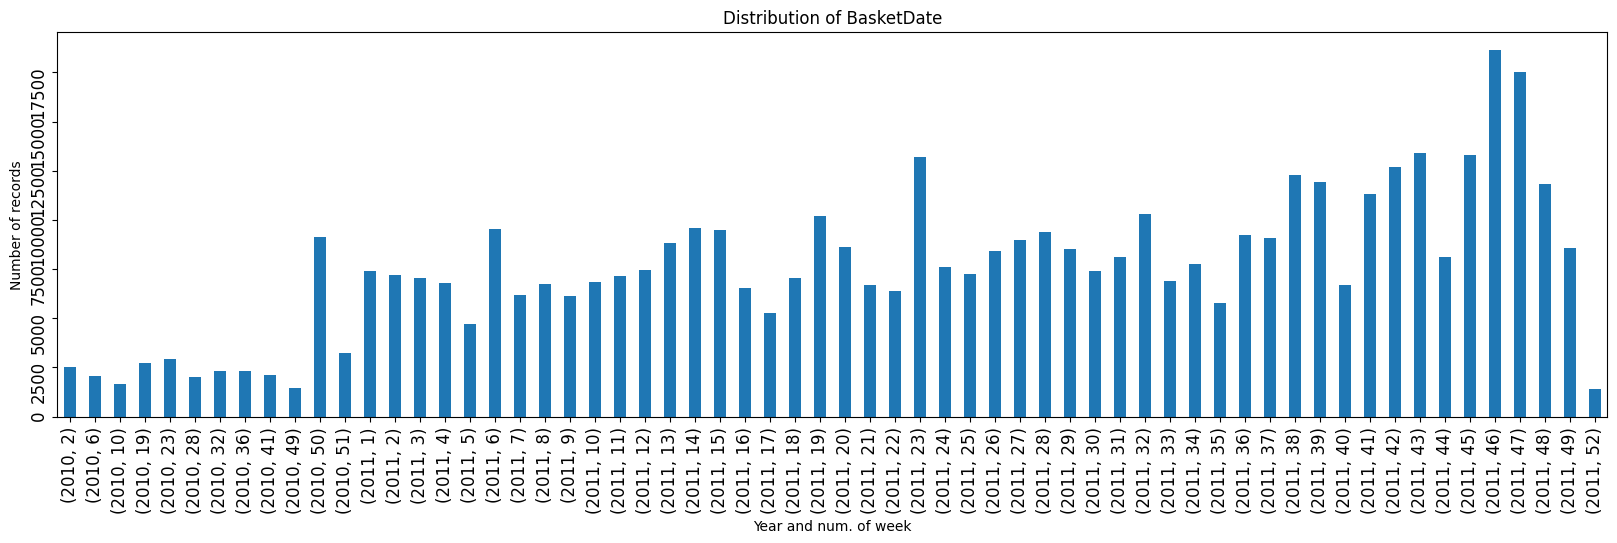

In [126]:
plt.figure(figsize=(20, 5))
df['BasketDate'].groupby([df.BasketDate.dt.year, df.BasketDate.dt.isocalendar().week]).agg('count').plot(kind="bar")
plt.title("Distribution of BasketDate")
plt.xlabel("Year and num. of week")
plt.ylabel("Number of records")
plt.tick_params(labelrotation=90, labelsize='large')
plt.show()

We now provide a deeper insight regarding the distribution of the records among years.

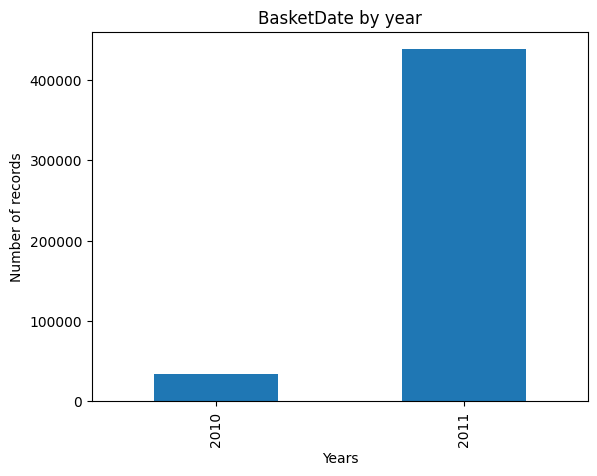

In [127]:
df['BasketDate'].groupby(df.BasketDate.dt.year).agg('count').plot(kind="bar")
plt.title("BasketDate by year")
plt.xlabel("Years")
plt.ylabel("Number of records")
plt.show()

The abundancy of records dated in 2011 with respect to those dated in 2010 is clear.

We now display the distribution of the records among the months, here expressed by a number between 1 and 12.

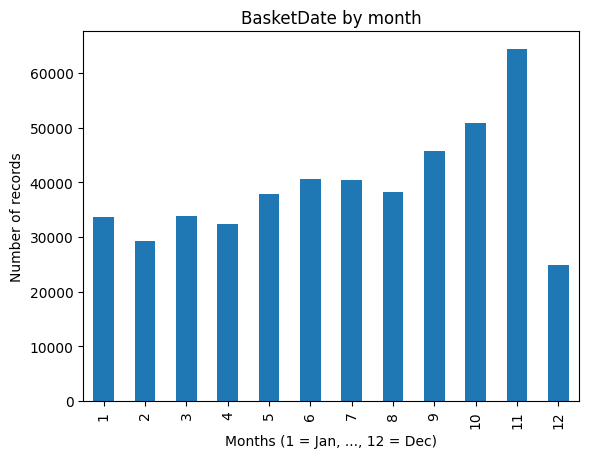

In [128]:
df['BasketDate'].groupby(df.BasketDate.dt.month).agg('count').plot(kind="bar")
plt.title("BasketDate by month")
plt.xlabel("Months (1 = Jan, ..., 12 = Dec)")
plt.ylabel("Number of records")
plt.show()

Here, a noticeable increase in the number of records, and thus transactions, happens during the last months preceding december. Said behaviour could be related to the occurance of festivities like Christmas but the low population on december itself seems opposing such theory.

We proceed by displaying the distribution of the records among the day of the week, here expressed by a nummber between 0 and 6.

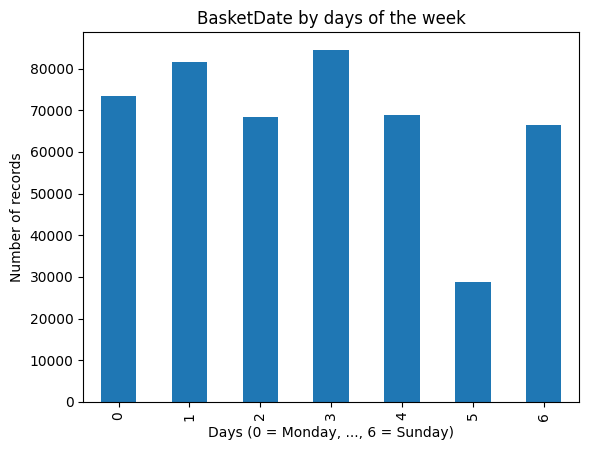

In [129]:
df['BasketDate'].groupby(df.BasketDate.dt.weekday).agg('count').plot(kind="bar")
plt.title("BasketDate by days of the week")
plt.xlabel("Days (0 = Monday, ..., 6 = Sunday)")
plt.ylabel("Number of records")
plt.show()

Here an expected behaviour could be a decreasing of records toward the end of the week, similarly to how the records from Saturday behave, but the records population dated on Sunday seems to oppose such assumption. 

We lastly display the distribution of records among the hours of the day.

In [130]:
df['BasketDate'].groupby(df.BasketDate.dt.hour).agg('count').plot(kind="bar")
plt.title("BasketDate by hours of the day")
plt.xlabel("Hours")
plt.ylabel("Number of records")

Text(0, 0.5, 'Number of records')

Here we can infer the business hours of the selling store, physical or not, as starting at 6.00 AM and ending before 9.00 PM. The record rise towards the middle hours of the day is also noticeable. 

#### Sale

As mentioned above, the Sale attribute has proven to be skewed. The magnitude of such skewness is measured thanks to the pandas function **skew()**.

In [131]:
df.Sale.skew()

np.float64(251.77019439193742)

A positive value of such order represent a severe skewness toward the right side (along the x axis) of the distribution. 

Another metric able to describe the shape of the distribution is the Kurtosis. Such metric is responsible of measuring the distribution's peakedness.

In [132]:
df.Sale.kurt()

np.float64(107198.9312919793)

According to both metrics the distribution of values from the Sale attribute is supposed to be extremely tall and thin with most of the values on the right side of horizontal axis. 

Such premises are quite confirmed by the histogram displayed next.

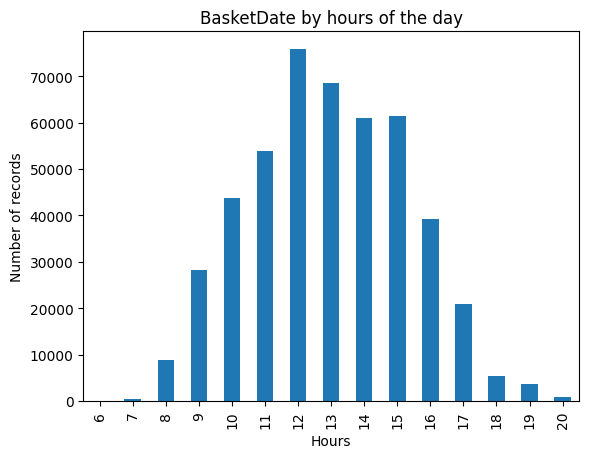

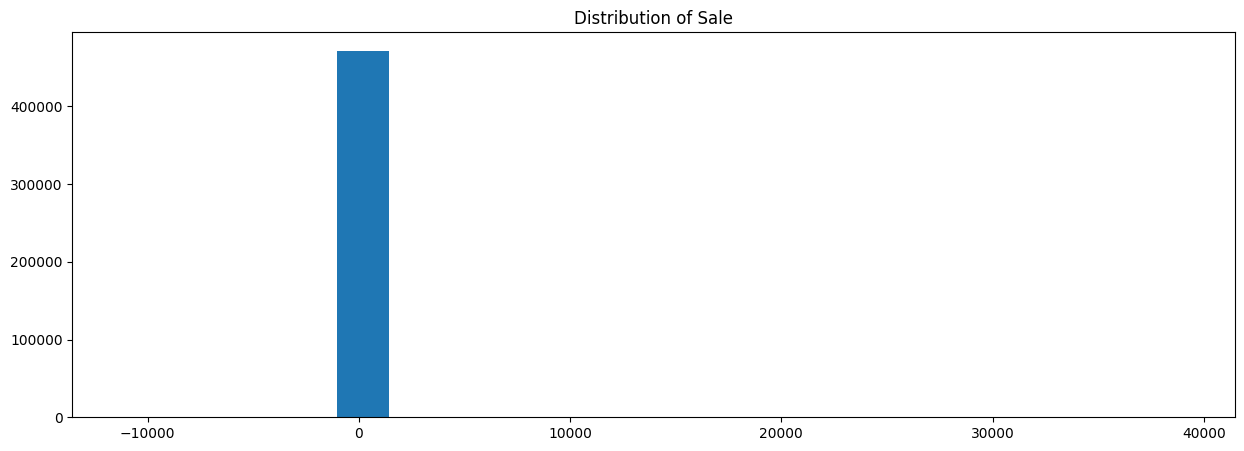

In [133]:
f, axs = plt.subplots(figsize=(15,5))
axs.hist(df.Sale, bins='sturges')
axs.set_title("Distribution of Sale")
plt.show() 

The presence of outliers and the severe difference in scale among the values associated with the Sale attribute doesn't permit a clear visualization of their distribution. 

We assume to be able to display more meaningful graphs after the process of outliers elimination performed within the **Assessing and Improving Data Quality** and, as such, we delay such plots at after the aforementioned activity. 

#### CustomerID

We calculate the total number of distinct values for the attribute CustomerID contained within the records from the dataset.

In [134]:
len(df.CustomerID.unique())

4373

#### CustomerCountry

Assuming *CustomerCountry* as a categorical attribute with a relatively small set of possible values, we determine the actual range of it throught the code below.

In [135]:
df.CustomerCountry.value_counts().count()

np.int64(38)

We now explore the distribution of records among these values.  

In [136]:
df.CustomerCountry.value_counts()

CustomerCountry
United Kingdom          426261
Germany                   9495
France                    8525
EIRE                      7824
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1932
Portugal                  1495
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                340
USA                        291
Israel                     269
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  138
Malta                      127
United Arab Emirates        68
European Community          61
RSA                    

Among them, the value "**United Kingdom**", being present within the 90% of the records in the dataset, is the most frequent one.

In [137]:
uk_percentage = df[df.CustomerCountry == "United Kingdom"].CustomerCountry.size # number of records with CustomerCountry equals to "United Kingdom"
tot_rows = df.CustomerCountry.size # number of rows within the dataframe
uk_percentage = (uk_percentage / tot_rows)*100
print(uk_percentage)

90.32675722065649


Also, 340 different records present the value "**Unspecified**" for the attribute in question. <br>(See the subsection **Handling missing values**) 

We now display the distribution of values for the CustomerCountry attribute. In order to account to the difference in scale between the number of records with value 'United Kingdom' and the other ones, we present an additional chart that does not take the former into account.

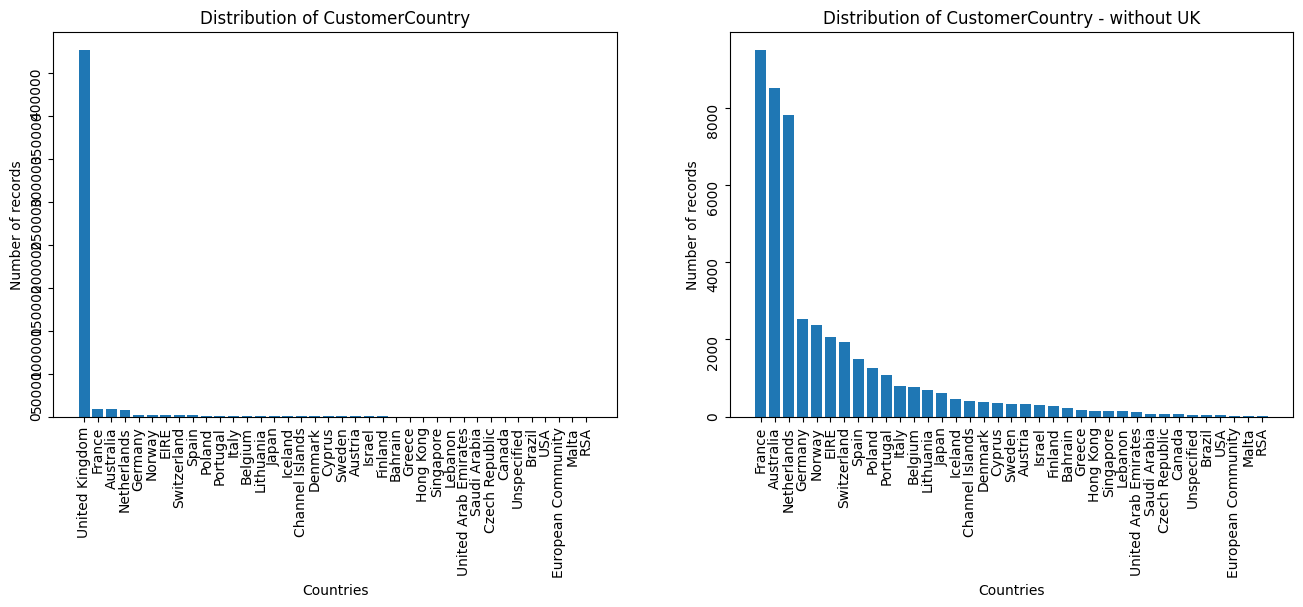

In [138]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(df.CustomerCountry.unique(),df.CustomerCountry.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Distribution of CustomerCountry")
axs[0].set_xlabel("Countries")
axs[0].set_ylabel("Number of records")

axs[1].bar(df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique(), df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Distribution of CustomerCountry - without UK")
axs[1].set_xlabel("Countries")
axs[1].set_ylabel("Number of records")

plt.show() 

#### ProdID

We calculate the total number of distinct values for the attribute ProdID contained within the records from the dataset.

In [139]:
len(df.ProdID.unique())

3953

#### ProdDescr

We calculate the total number of distinct values for the attribute ProdDescr contained within the records from the dataset.

In [140]:
len(df.ProdDescr.unique())

4098

#### Qta

Just as for the values from the Sale attribute, the ones from Qta, have displayed the potential for skewness. We again compute both the skewness and the Kurtosis of said distribution.

In [141]:
df.Qta.skew()

np.float64(0.20476694612755061)

In [142]:
df.Qta.kurt()

np.float64(108564.38223523657)

While still displaying the kurtosis of a very tall and thin distribution, the values from Qta present a, still positive but, less steep skewness.

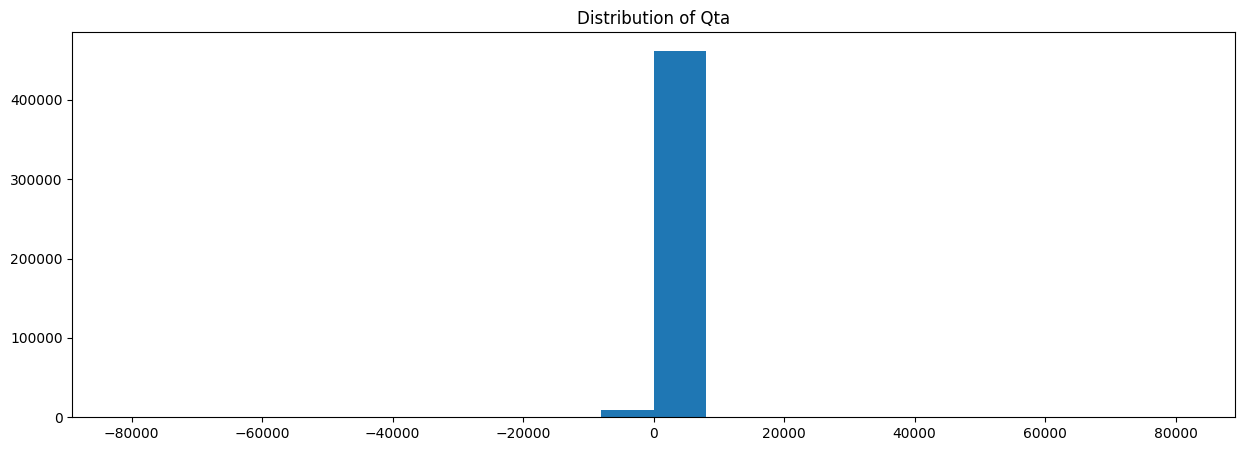

In [143]:
f, axs = plt.subplots(figsize=(15,5))
axs.hist(df.Qta, bins='sturges')
axs.set_title("Distribution of Qta")
plt.show() 

Again, we postpone a more clear and detailed version of the plot above at after the section **Assessing and improving Data Quality**.

## Assessing and improving Data Quality

### Handling duplicates

The pandas function **duplicated()** returns a list of boolean values where each *True* corresponds to the duplicate of a row within the dataframe. 

In [144]:
df.duplicated().any()

np.True_

In [145]:
df.duplicated().value_counts()

False    466678
True       5232
Name: count, dtype: int64

Having confirmed the presence of several duplicated rows within the dataframe, we print some of them as samples:

In [146]:
duplicates = df[df.duplicated()]
duplicates.head()

BasketID          BasketDate  Sale CustomerID CustomerCountry ProdID  \
517   536409 2010-01-12 11:45:00  1.25   17908.00  United Kingdom  21866   
527   536409 2010-01-12 11:45:00  2.10   17908.00  United Kingdom  22866   
537   536409 2010-01-12 11:45:00  2.95   17908.00  United Kingdom  22900   
539   536409 2010-01-12 11:45:00  4.95   17908.00  United Kingdom  22111   
555   536412 2010-01-12 11:49:00  2.95   17920.00  United Kingdom  22327   

                             ProdDescr  Qta  
517        UNION JACK FLAG LUGGAGE TAG    1  
527      HAND WARMER SCOTTY DOG DESIGN    1  
537    SET 2 TEA TOWELS I LOVE LONDON     1  
539       SCOTTIE DOG HOT WATER BOTTLE    1  
555  ROUND SNACK BOXES SET OF 4 SKULLS    1

We print a couple of records consisting in an "original" row and its duplicate.

In [147]:
df[(df.ProdDescr == "UNION JACK FLAG LUGGAGE TAG") & (df.CustomerID == 17908)]

BasketID          BasketDate  Sale CustomerID CustomerCountry ProdID  \
494   536409 2010-01-12 11:45:00  1.25   17908.00  United Kingdom  21866   
517   536409 2010-01-12 11:45:00  1.25   17908.00  United Kingdom  21866   

                       ProdDescr  Qta  
494  UNION JACK FLAG LUGGAGE TAG    1  
517  UNION JACK FLAG LUGGAGE TAG    1

Assuming, <u>by personal interpretation</u>, the presence of duplicate records as the result of errors during data entry, and not as the intentional addition of multiple transactions, they are deleted from the dataset.

In [148]:
df.drop_duplicates(inplace=True)
df.duplicated().any()

np.False_

### Handling missing values

#### Missing values detection

We confirm what was established by the **info()** function regarding missing values within the dataset by making use of the pandas function **isnull()**.

In [149]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

As mentioned above, the columns *CustomerID* and *ProdDescr* present missing values.

Other missing values could also be contained within the columns of numerical attributes like *Qta* or *Sale* (i.e. represented by a 0),
therefore, specific code needs to be written in order to check for these cases.

##### Missing values in *Sale* and *Qta*

We search for values equal to zero within both of the attributes.

In [150]:
df[df.Qta == 0].Qta.count() #Zero values in Qta

np.int64(0)

In [151]:
df[df.Sale == 0].Sale.count() #Zero values in Sale

np.int64(1278)

The sales column has several records with values equal to zero but, given the transactional
nature of the dataset under examination, we believe that the aforementioned
zero values do retain a useful significance for the purposes of our analysis.

Therefore, these attributes are not going to be involved in the process of replacing
missing values which is now focused only on the categorical attributes of the dataset.

##### Missing values in *CustomerCountry*

We compute a list of all the different values associated with the *CustomerCountry* attribute.

In [152]:
df.CustomerCountry.value_counts()

CustomerCountry
United Kingdom          421106
Germany                   9480
France                    8509
EIRE                      7814
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1931
Portugal                  1486
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                337
USA                        291
Israel                     266
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  137
Malta                      127
United Arab Emirates        68
European Community          61
RSA                    

The list above presents an "**Unspecified**" value for *CustomerCountry* associated with 340 different records. 
Given the inherent ambiguity of the value we consider it a strong candidate for a replacement with values with a stronger statistical significance.

Before committing to this decision, however, we check for the values within the *CustomerID* column of the records that present an "Unspecified" *CustomerCountry*.
Other transactions of the same customers, represented here by other records with the same value for *CustomerID*, may display a different value of *CustomerCountry* suitable to replace the others.

We compute a list of all the values for *CustomerID* associated with records with an "Unspecified" *CustomerCountry*.

In [153]:
unspecified_ids = df[df.CustomerCountry == 'Unspecified'].CustomerID.value_counts()
unspecified_ids.keys()

Index([12743.0, 16320.0, 14265.0, 12363.0], dtype='object', name='CustomerID')

We now check for every value of *CustomerCountry* associated with said values of *CustomerID*.

In [154]:
df.loc[df.CustomerID.isin(unspecified_ids.keys())].CustomerCountry.value_counts()

CustomerCountry
Unspecified    241
Name: count, dtype: int64

Only 241 records result associated with the aforementioned values of *CustomerID*. 

In order to ascertain the state of the 96 unaccounted rows, we now count the number of records with an "Unspecified" *CustomerCountry* and a NaN *CustomerID*.

In [155]:
nan_count = df[df.CustomerCountry == "Unspecified"].isna().CustomerID.value_counts()
nan_count

CustomerID
False    241
True      96
Name: count, dtype: int64

We have confermed that none of the records we have referred to are associated with a value for *CustomerCountry* other than "Unspecified".
This set of records therefore acts as an autonomous group.

While it is still possible to replace the values in question with the most frequent value of this attribute (in this case United Kingdom), we believe it is more interesting to wait for the results of the clustering process in view of a hypothetical grouping with records associated with another particular country.

#### Missing values replacement

##### Replacing the missing values from CustomerID

The CustomerID column presents several records containing missing values.

In [156]:
df.CustomerID.isnull().sum()

np.int64(65073)

We decide to replace each missing value depending on the value for CustomerCountry contained within its record. We select the most frequent IDs in a given *CustomerCountry*, basically computing the mode over a subset of the *CustomerID* column and use those values as substitutes for the missing ones.

These are the most frequent CustomerID for each *CustomerCountry*:

In [157]:
country_mode = df.groupby(['CustomerCountry']).agg(lambda x:x.mode()).CustomerID
country_mode

CustomerCountry
Australia              12415.00
Austria                12360.00
Bahrain                12355.00
Belgium                12362.00
Brazil                 12769.00
Canada                 17444.00
Channel Islands        14936.00
Cyprus                 12359.00
Czech Republic         12781.00
Denmark                12406.00
EIRE                   14911.00
European Community     15108.00
Finland                12428.00
France                 12681.00
Germany                12471.00
Greece                 12717.00
Hong Kong                    []
Iceland                12347.00
Israel                 12688.00
Italy                  12584.00
Japan                  12753.00
Lebanon                12764.00
Lithuania              15332.00
Malta                  17828.00
Netherlands            14646.00
Norway                 12433.00
Poland                 12779.00
Portugal               12757.00
RSA                    12446.00
Saudi Arabia           12565.00
Singapore              1

No CustomerID is associated with any of the records with *CustomerCountry* equals to "Hong Kong". For the sake of replacing these empty values we craft a custom CustomerID and add it to the aforementioned list. 

Here we check to see if the custom ID is already present within the dataset.

In [158]:
df[df.CustomerID == "18288.0"].CustomerID.count() #We check to see if the custom ID is already present within the dataset 

np.int64(0)

Being it currently absent from the dataset we confirm our choice as custom CustomerID for the records from Hong Kong.

In [159]:
country_mode["Hong Kong"] = "18288.0"

Now we substitute each missing value with the corresponding element from the list.

In [160]:
#We replace the missing values from CustomerID with the elements from country_mode
df['CustomerID'] = df.apply(
    lambda row: country_mode[row['CustomerCountry']] if pd.isnull(row['CustomerID']) else row['CustomerID'],
    axis=1
)

After the process the number of missing values is down to zero.

In [161]:
df.CustomerID.isnull().sum()

np.int64(0)

### Handling the records related to canceled purchases

We already described the interesting characteristic of such couples of records within the section dedicated to the statistics of the dataset. 

This is the current amount of records with negative values for Qta within the dataset.

In [162]:
print('Records within the dataset: ' + str(df.BasketID.count()))
print('Records within the dataset with negative values of Qta: ' + str(df[df.Qta < 0].BasketID.count()))
print('Records within the dataset with negative values of Qta and BasketId containing \'C\': ' + str(df[(df.Qta < 0) & (df.BasketID.str.contains('C'))].BasketID.count()))

Records within the dataset: 466678
Records within the dataset with negative values of Qta: 9719
Records within the dataset with negative values of Qta and BasketId containing 'C': 9051


We now implement the balancing procedure previously mentioned. 

In [163]:
neg_purchases = df[df.Qta < 0]
for neg_purchase in neg_purchases.iterrows(): # selects each record with a negative value for Qta
    neg_index = neg_purchase[0]
    neg_customerID = neg_purchase[1].CustomerID
    neg_prodID = neg_purchase[1].ProdID
    neg_Qta = neg_purchase[1].Qta
    pos_purchases = df[(df.CustomerID == neg_customerID ) & (df.ProdID == neg_prodID ) & (df.Qta > 0)] # identifies the transactions from the same customer
                                                                                                       # for the same product with a positive value of Qta
    for pos_purchase in pos_purchases.iterrows(): # selects each record with a positive value for Qta
        if  pos_purchase[1].Qta == abs(neg_Qta):# if the two values of Qta are opposite then both negative and positive records are dropped
            df.drop([neg_index, pos_purchase[0]], inplace=True)
            break
        elif pos_purchase[1].Qta > abs(neg_Qta): # if the positive value for Qta is bigger than the negative one then the negative record is dropped and the positive Qta value is updated
            df.loc[pos_purchase[0]].Qta = pos_purchase[1].Qta - abs(neg_Qta)
            df.drop([neg_index], inplace=True)
            break
        else: # if the negative value for Qta is bigger than the positive one then the positive record is dropped and the negative Qta value is updated
            neg_Qta = neg_Qta + pos_purchase[1].Qta
            df.drop([pos_purchase[0]], inplace=True)
        df.loc[neg_index].Qta = neg_Qta

C:\Users\user\AppData\Local\Temp\ipykernel_30388\678874564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[pos_purchase[0]].Qta = pos_purchase[1].Qta - abs(neg_Qta)
C:\Users\user\AppData\Local\Temp\ipykernel_30388\678874564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[pos_purchase[0]].Qta = pos_purchase[1].Qta - abs(neg_Qta)
C:\Users\user\AppData\Local\Temp\ipykernel_30388\678874564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

This is the amount of records with negative values for Qta within the dataset after applying the procedure above.

In [164]:
print('Records within the dataset: ' + str(df.BasketID.count()))
print('Records within the dataset with negative values of Qta: ' + str(df[df.Qta < 0].BasketID.count()))
print('Records within the dataset with negative values of Qta and BasketId containing \'C\': ' + str(df[(df.Qta < 0) & (df.BasketID.str.contains('C'))].BasketID.count()))

Records within the dataset: 450413
Records within the dataset with negative values of Qta: 1553
Records within the dataset with negative values of Qta and BasketId containing 'C': 1078


16265 records are deleted from the dataset, among them:
- 8099, with positive Qta values, correspond to the purchase of products which are then returned.
- 8166, with negative Qta values, correspond to the actual return of the same.

In [165]:
df.describe()

BasketDate      Sale       Qta
count                         450413 450413.00 450413.00
mean   2011-06-19 03:28:21.645068288      3.76     11.26
min              2010-01-12 08:26:00 -11062.06  -9360.00
25%              2011-03-28 09:21:00      1.25      2.00
50%              2011-07-06 17:12:00      1.95      4.00
75%              2011-10-06 15:07:00      3.75     12.00
max              2011-12-10 17:19:00  38970.00  12540.00
std                              NaN     80.99     48.16

### Handling outliers

#### Outliers Detection

We have already mentioned how both the *Sale* and *Qta* attributes contain very high values that could be easily classified as outliers, here we provide a deeper analysis of said phenomenon.

These are the boxplots for the two attributes computed by the pandas function **boxplot()**:

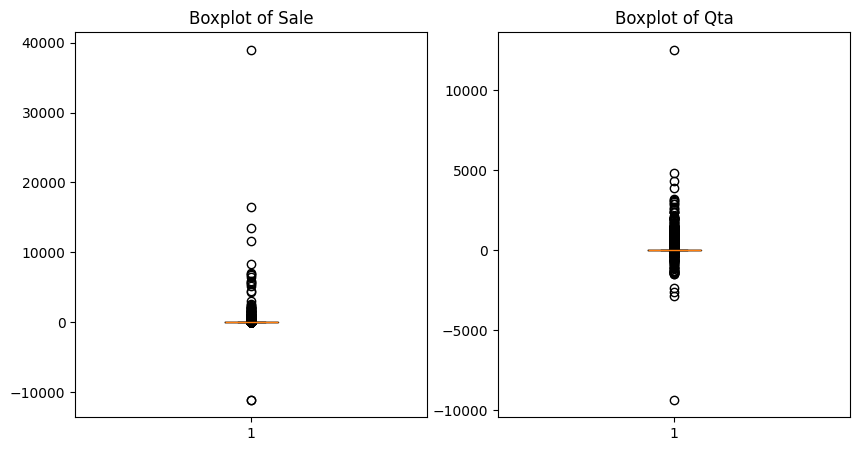

In [166]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].boxplot(df.Sale)
axs[0].set_title('Boxplot of Sale')
axs[1].boxplot(df.Qta)
axs[1].set_title('Boxplot of Qta')
plt.show()

Indeed both plots seem to be deeply affected by outliers. 
We proceed by computing the **interquantile range** (**IQR**) and by limiting the plot to the points within it.

We start by defining a function for computing the IQR:

In [167]:
def iqr_values(s): 
    q1 = s.quantile(q = 0.25)
    q3 = s.quantile(q = 0.75)
    iqr = q3 - q1
    iqr_left = q1 - 1.5*iqr
    iqr_right = q3 + 1.5*iqr
    return iqr_left, iqr_right

Now we apply said function to *Sale* and plot the new boxplot. 

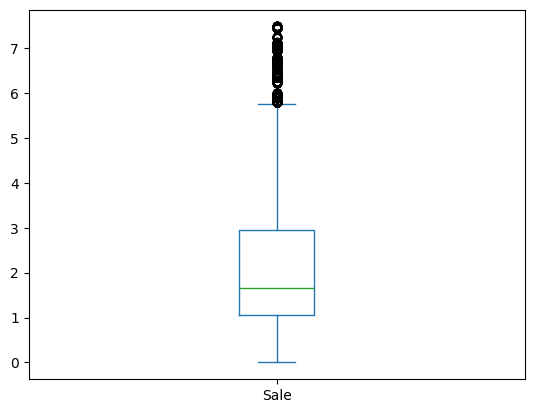

In [168]:
left_sale, right_sale = iqr_values(df.Sale)
df[(df.Sale > left_sale) & (df.Sale < right_sale)].Sale.plot.box()
plt.show()

We do the same the *Qta* attribute.

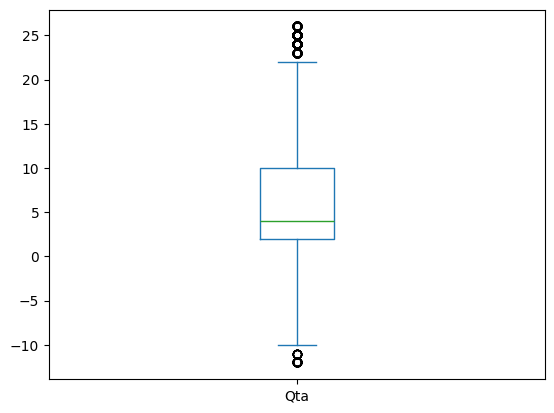

In [169]:
left_qta, right_qta = iqr_values(df.Qta)
df[(df.Qta > left_qta) & (df.Qta < right_qta)].Qta.plot.box()
plt.show()

We select the records containing outliers for the *Sale* and *Qta* attributes.

In [170]:
df_outliers = df[(df.Sale < left_sale) | (df.Sale > right_sale) | (df.Qta < left_qta) | (df.Qta > right_qta)]
df_outliers

BasketID          BasketDate  Sale CustomerID CustomerCountry ProdID  \
5        536365 2010-01-12 08:26:00  7.65   17850.00  United Kingdom  22752   
13       536367 2010-01-12 08:34:00  1.69   13047.00  United Kingdom  84879   
20       536367 2010-01-12 08:34:00  9.95   13047.00  United Kingdom  22622   
23       536367 2010-01-12 08:34:00  7.95   13047.00  United Kingdom  21777   
24       536367 2010-01-12 08:34:00  7.95   13047.00  United Kingdom  48187   
...         ...                 ...   ...        ...             ...    ...   
541866   581583 2011-09-12 12:23:00  1.85   13777.00  United Kingdom  85038   
541867   581584 2011-09-12 12:25:00  0.72   13777.00  United Kingdom  20832   
541868   581584 2011-09-12 12:25:00  1.85   13777.00  United Kingdom  85038   
541892   581586 2011-09-12 12:49:00  8.95   13113.00  United Kingdom  21217   
541909   581587 2011-09-12 12:50:00 18.00   12680.00          France   POST   

                               ProdDescr  Qta  
5           SET 7 BABUSHKA NESTING BOXES    2  
13         ASSORTED COLOUR BIRD ORNAMENT   32  
20        BOX OF VINTAGE ALPHABET BLOCKS    2  
23           RECIPE BOX WITH METAL HEART    4  
24                   DOORMAT NEW ENGLAND    4  
...                                  ...  ...  
541866   6 CHOCOLATE LOVE HEART T-LIGHTS   36  
541867  RED FLOCK LOVE HEART PHOTO FRAME   72  
541868   6 CHOCOLATE LOVE HEART T-LIGHTS   48  
541892     RED RETROSPOT ROUND CAKE TINS   24  
541909                           POSTAGE    1  

[68848 rows x 8 columns]

We delete said records from the dataframe.

In [171]:
df.drop(df_outliers.index, inplace=True)

### Extra: New Distributions of Sale and Qta

We now check again for skewness and Kurtonis in both the populations of Sale and Qta.

In [172]:
print('Sale:')
print('Skewness: ' + str(df.Sale.skew()))
print('Kurtonis: ' + str(df.Sale.kurt()))

Sale:
Skewness: 1.0154725590047817
Kurtonis: 0.4065465345496655


The Sale attribute still presents a positive skewness which is clearly less intense than before. Its Kurtonis however is also greatly reduce so, its population should be more flat and wide than before.

In [173]:
print('Qta:')
print('Skewness: ' + str(df.Qta.skew()))
print('Kurtonis: ' + str(df.Qta.kurt()))

Qta:
Skewness: 1.314628915417578
Kurtonis: 0.9932034153710703


The skewness and Kurtonis values for the Qta attribute still suggest a tall distribusion skewed toward the right side of the axis but both behavious should be far less intense than before.

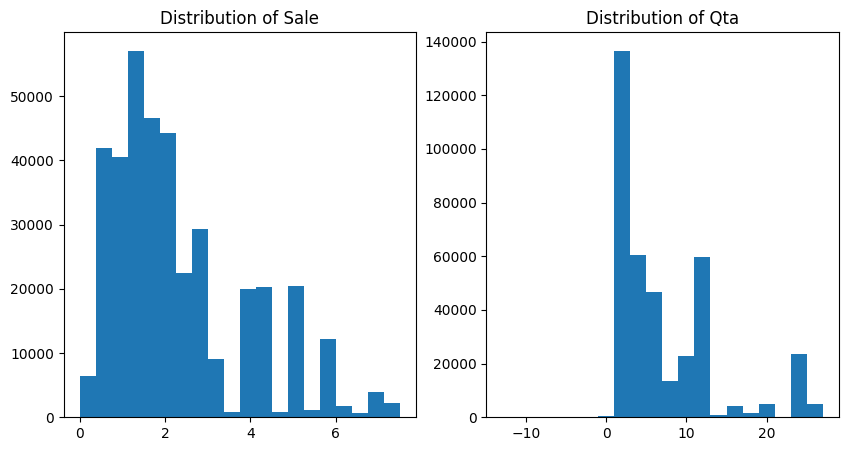

In [174]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].hist(df.Sale, bins='sturges')
axs[0].set_title('Distribution of Sale')
axs[1].hist(df.Qta, bins='sturges')
axs[1].set_title('Distribution of Qta')
plt.show() 

Such premises are confermed by the populatons dispayed by the histograms above.

## Correlation

We now compute the correlation matrix related to the numerical attributes of the dataset.

In [178]:
mat = df[['Sale', 'Qta']].corr()

The matrix above can be also used as a parameter for the seaborn function **heatmap()**. This will plot a matrix where the color of the cell corresponds to the intensity of the correlation among the attributes. 

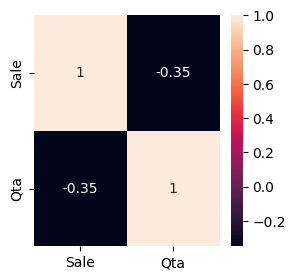

In [179]:
fig, ax = plt.subplots(figsize=(3,3))         # Sample figsize in inches
sn.heatmap(mat, annot=True)
plt.show()

### Scatter Plots

We proceed by visualizing the correlation through the use of scatterplots. 

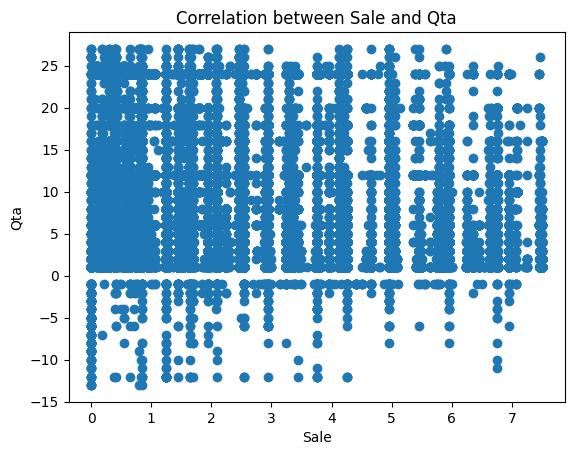

In [180]:
plt.scatter(df['Sale'], df['Qta'])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.title('Correlation between Sale and Qta')
plt.show()

## Data Transformation

### Sale as cost for unit and Sale_per_Qta

Assuming the values for Sale as the cost of one single unit of the products identified by ProdID, and in order to account to the total amount spent by each customer for its transactions, we compute an additional indicator called Sale_per_Qta.

In [181]:
df['Sale_per_Qta'] = df.Sale.mul(df.Qta)

We now plot the distribution of the aforementioned attribute.

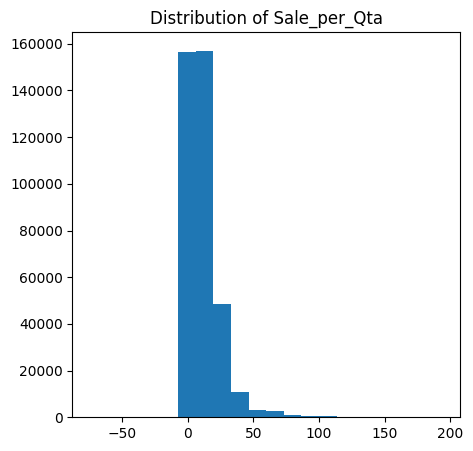

In [182]:
f, axs = plt.subplots(figsize=(5,5))
axs.hist(df.Sale_per_Qta, bins='sturges')
axs.set_title("Distribution of Sale_per_Qta")
plt.show() 

## Data Visualization

We include the following function in order to help with the visualization of the data. Said function will interact with the bars from a bar plot by adding their cardinality on top of each rectangle.

In [183]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axs[i][j].annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    elif i != None:
        for rect in rects:
            height = rect.get_height()
            axs[i].annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    else:
        for rect in rects:
            height = rect.get_height()
            axs.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

### Periodical Plots

In order to build plots displaying the behaviour of attributes like Sale and Qta over period of times, we create an *ad hoc dataframe* by duplicating the original one and setting the BaskeDate attribute as index.

In [184]:
df2 = df.copy()
df2.index = pd.to_datetime(df['BasketDate'], format='%d/%m/%y %H:%M')

#### Dividing the observation period in months: Monthly sales and quantities

We display the behaviour of both the Sale and Qta attributes over the months within our period of observation, both as mean and total value.

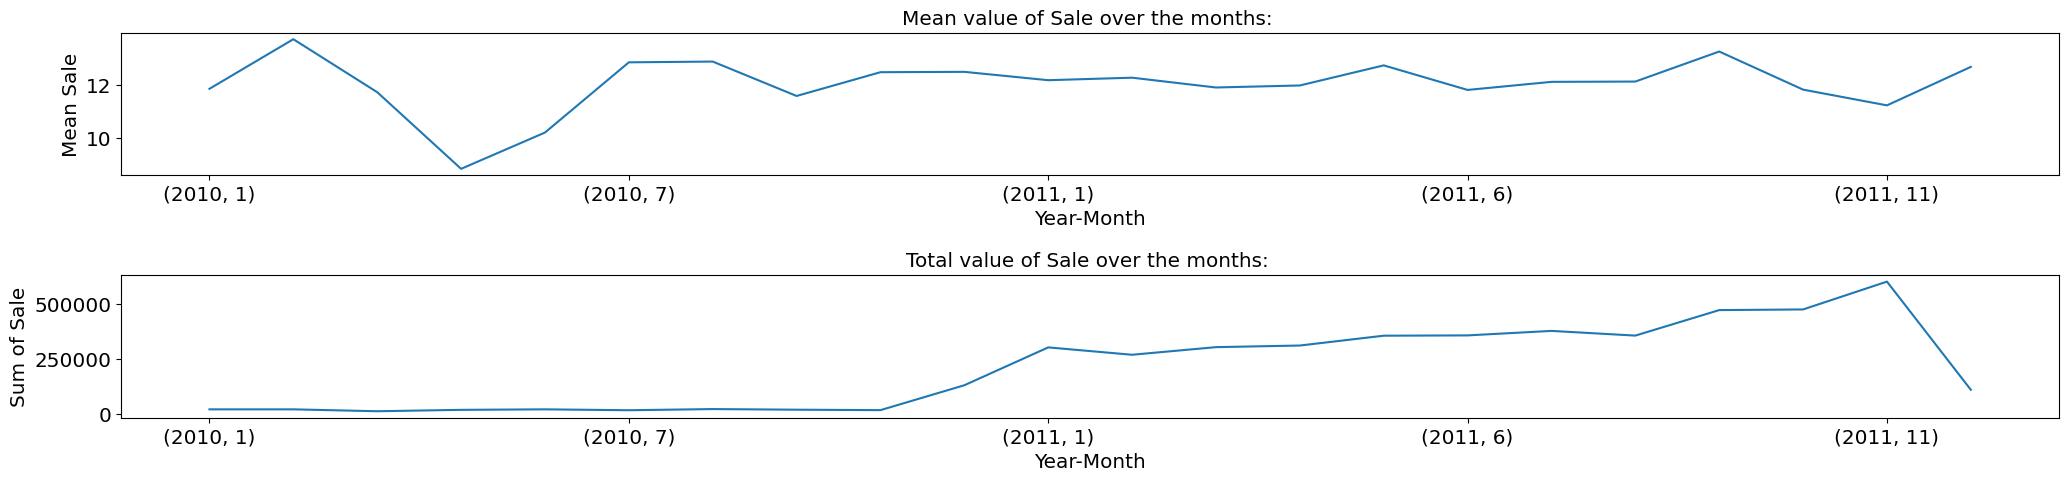

In [185]:
# Set up a grid of plots:
fig = plt.figure(figsize=(25, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.month]).mean().plot()
plt.title('Mean value of Sale over the months: ', fontsize='x-large')
plt.xlabel('Year-Month', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.month]).sum().plot()
plt.title('Total value of Sale over the months: ', fontsize='x-large')
plt.xlabel('Year-Month', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

The shortage of observations from the year 2010 is highlighted by the values for the total amount spent by the customers within the first half of the graph above.


#### Dividing the observation period in weeks: Weekly sales and quantities

We display the behaviour of both the Sale and Qta attributes over the weeks within our period of observation, both as mean and total value.

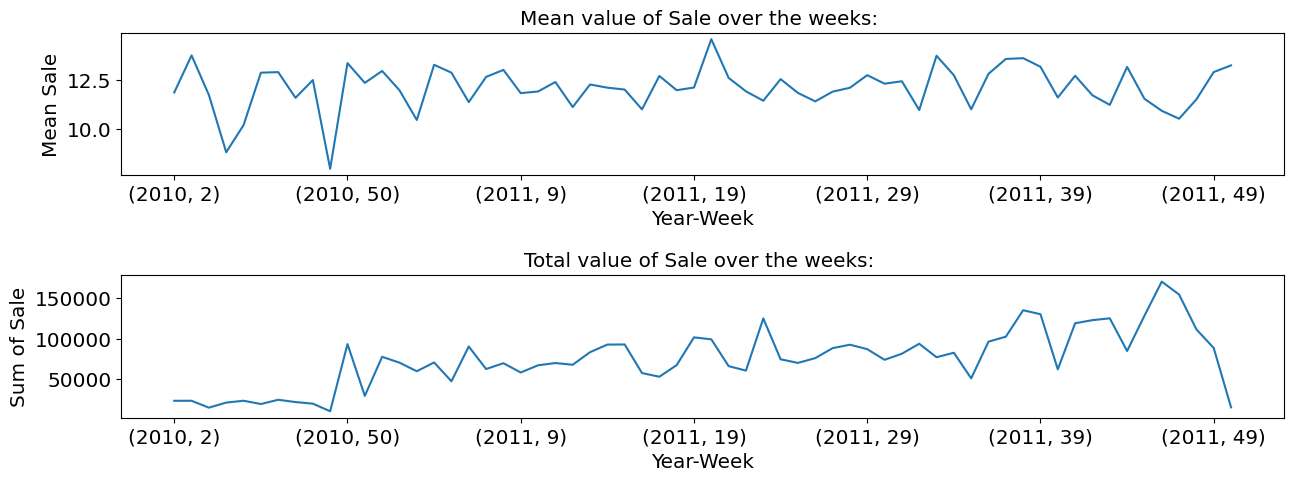

In [190]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.isocalendar().week]).mean().plot()
plt.title('Mean value of Sale over the weeks: ', fontsize='x-large')
plt.xlabel('Year-Week', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.isocalendar().week]).sum().plot()
plt.title('Total value of Sale over the weeks: ', fontsize='x-large')
plt.xlabel('Year-Week', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

#### Observing the behaviour of Sale and Qta over the month

We display the total and mean amount of both the Sale and Qta attributes over the course of the month.

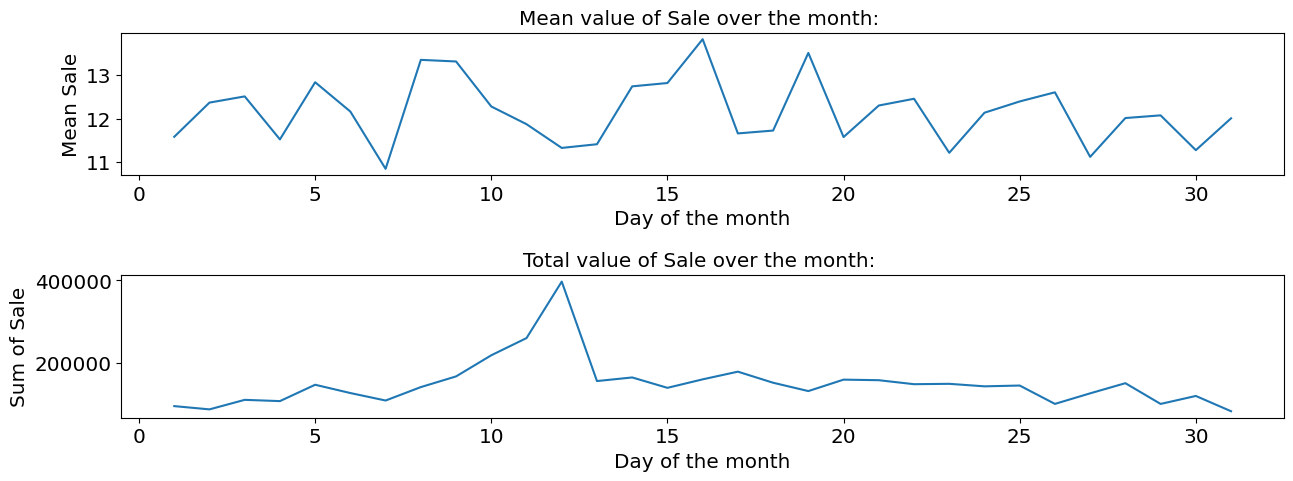

In [191]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.day).mean().plot()
plt.title('Mean value of Sale over the month: ', fontsize='x-large')
plt.xlabel('Day of the month', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.day).sum().plot()
plt.title('Total value of Sale over the month: ', fontsize='x-large')
plt.xlabel('Day of the month', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

#### Observing the behaviour of Sale and Qta over the week

We display the total and mean amount of both the Sale and Qta attributes over the course of the week.

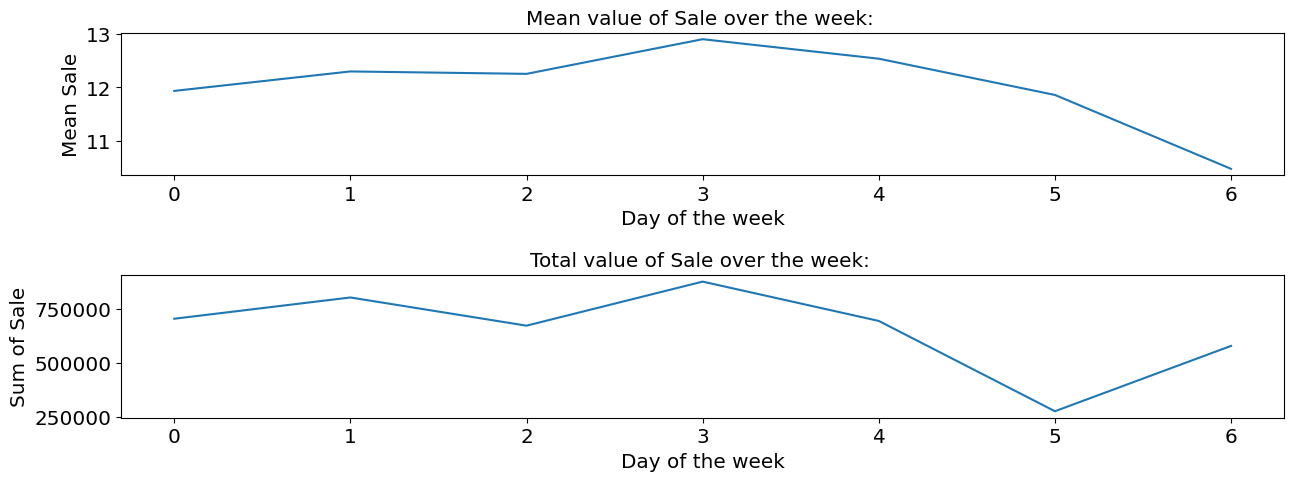

In [192]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.weekday).mean().plot()
plt.title('Mean value of Sale over the week: ', fontsize='x-large')
plt.xlabel('Day of the week', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.weekday).sum().plot()
plt.title('Total value of Sale over the week: ', fontsize='x-large')
plt.xlabel('Day of the week', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

Both graphs suggest an increase in both the number of purchases and their cost around Thursday. 
The low total amount spent by the customers around Saturday instead suggest an overall decrease in the number of purchases.

#### Observing the behaviour of Sale and Qta over the day

We display the total and mean amount of both the Sale and Qta attributes over the course of the day.

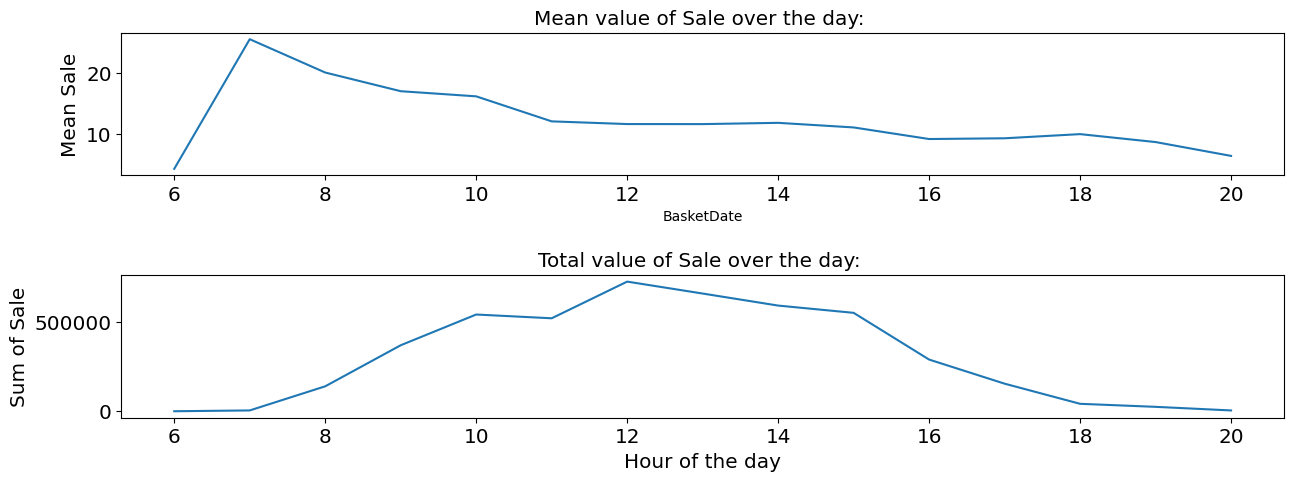

In [193]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.hour).mean().plot()
plt.title('Mean value of Sale over the day: ', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.hour).sum().plot()
plt.title('Total value of Sale over the day: ', fontsize='x-large')
plt.xlabel('Hour of the day', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

From the high mean and low total values during the morning we can infer the presence of few, but relatively costly, purchases during the store's first hours of activity.

Also, the medium mean and hight total values around the central hours of the day suggest the presence of several medium-small purchases. 

### Display the interaction of Sale and Qta with CustomerCountry

#### Number of Customer per CustomerCountry

Including the population with CustomerCountry equals to'United Kingdom' within the same plot of the remaining population would harm the scale among values and thus decrease the readability of the graphs. 

We therefore split the visualization of statistics between the UK population and the one with different values of CustomerCountry.

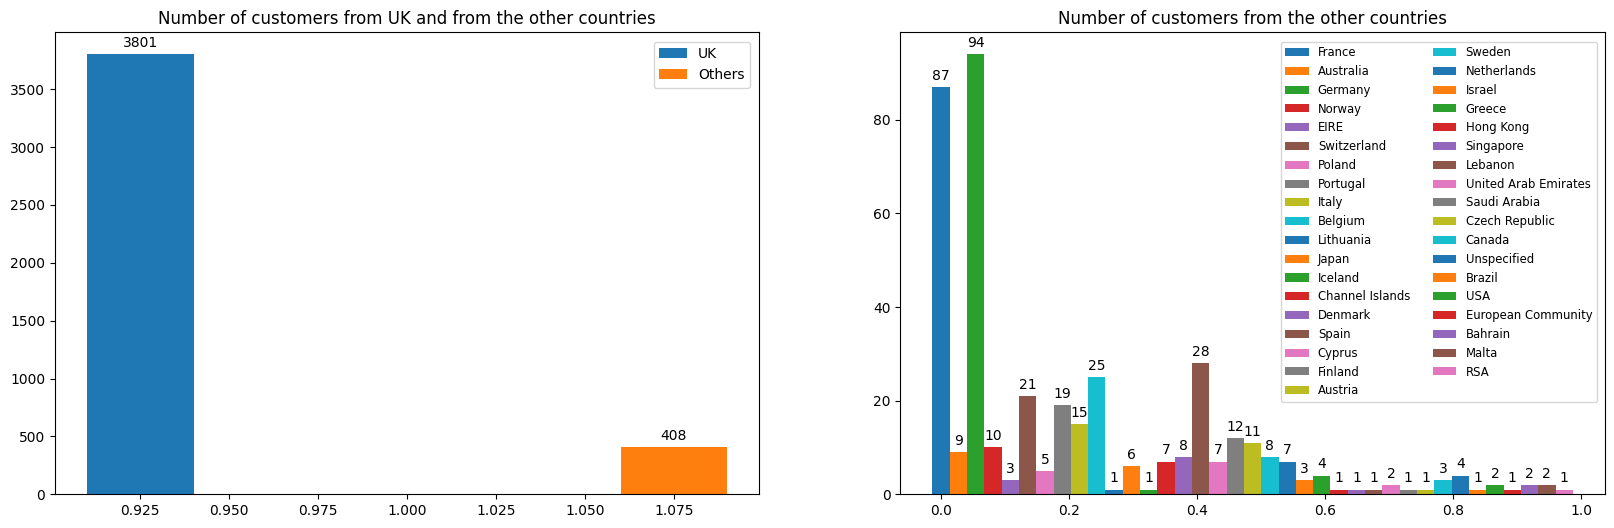

In [194]:
uk_cust = [len(df[df.CustomerCountry == 'United Kingdom'].CustomerID.unique())]
others_cust = [len(df[df.CustomerCountry != 'United Kingdom'].CustomerID.unique())]

width = 0.15

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

autolabel(axs[0].bar(1 - width/2, uk_cust, width/5, label='UK'), 0)
autolabel(axs[0].bar(1 + width/2, others_cust, width/5, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0.)
axs[0].set_title('Number of customers from UK and from the other countries')

other_countries = df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique()
for i in range(len(other_countries)):
    point = (1/len(other_countries) * i)
    autolabel(axs[1].bar(point, len(df[df.CustomerCountry == other_countries[i]].CustomerID.unique()), (1/len(other_countries)), label=other_countries[i]), 1)
axs[1].legend(bbox_to_anchor=(0.54, 0.98), loc='upper left', borderaxespad=0., ncol=2, fontsize='small')
axs[1].set_title('Number of customers from the other countries')

plt.show()

#### Total Sale_per_Qta per CustomerCountry

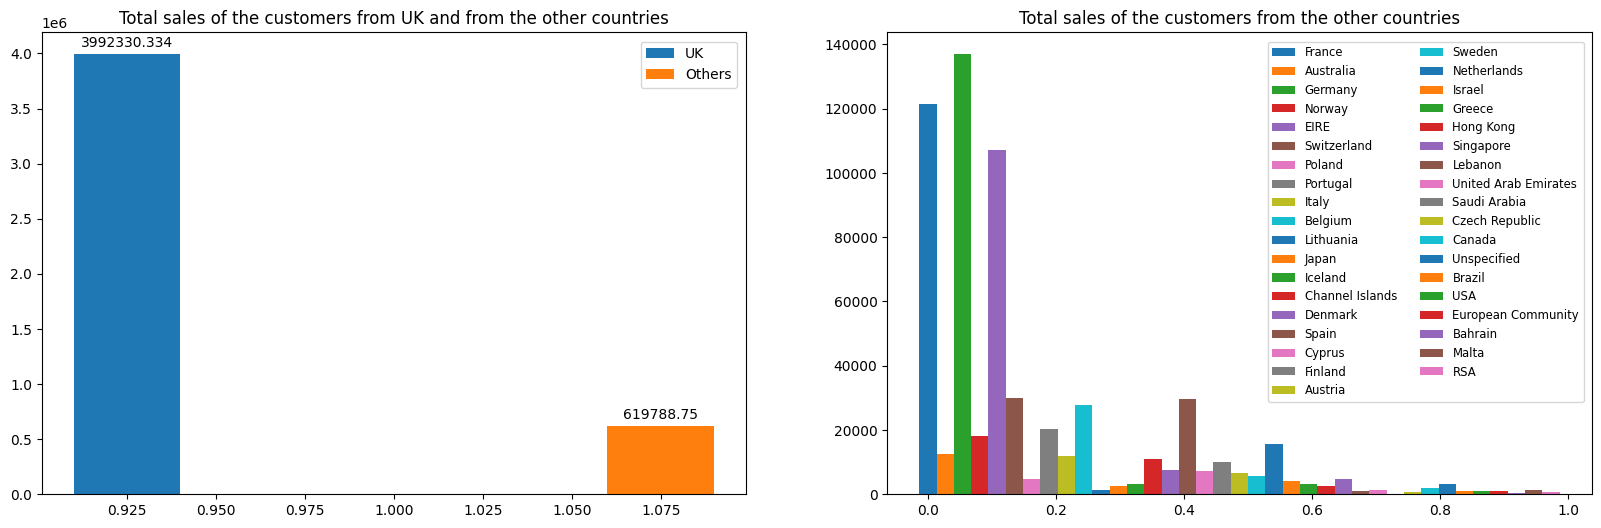

In [195]:
uk_cust = [df[df.CustomerCountry == 'United Kingdom'].Sale_per_Qta.sum()]
others_cust = [df[df.CustomerCountry != 'United Kingdom'].Sale_per_Qta.sum()]

width = 0.15

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

autolabel(axs[0].bar(1 - width/2, uk_cust, width/5, label='UK'), 0)
autolabel(axs[0].bar(1 + width/2, others_cust, width/5, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0.)
axs[0].set_title('Total sales of the customers from UK and from the other countries')

other_countries = df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique()
for i in range(len(other_countries)):
    point = (1/len(other_countries) * i)
    axs[1].bar(point, df[df.CustomerCountry == other_countries[i]].Sale_per_Qta.sum(), (1/len(other_countries)), label=other_countries[i])
axs[1].legend(bbox_to_anchor=(0.54, 0.98), loc='upper left', borderaxespad=0., ncol=2, fontsize='small')
axs[1].set_title('Total sales of the customers from the other countries')

plt.show()

#### Average Sale_per_Qta per CustomerCountry

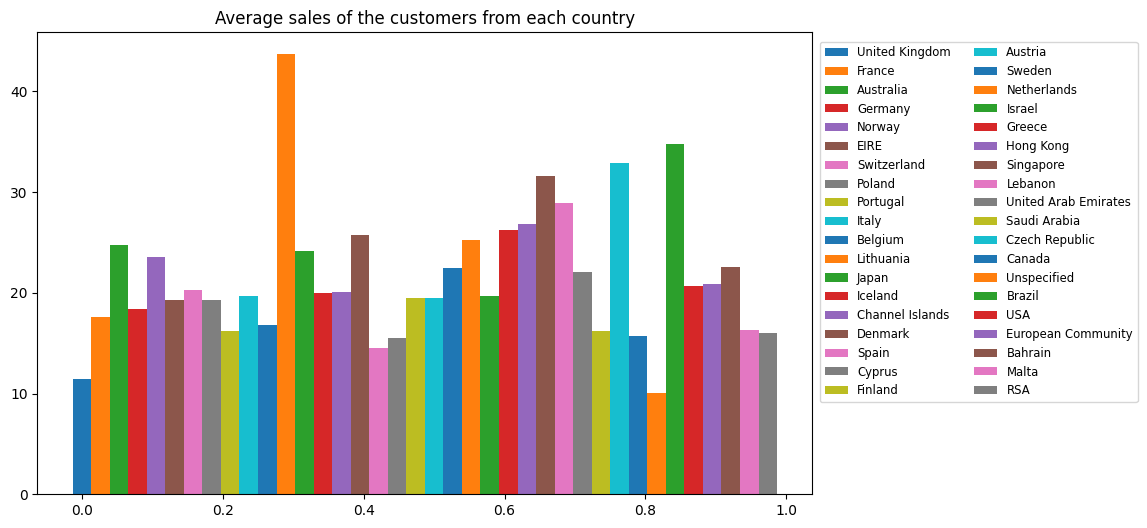

In [196]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

countries = df.CustomerCountry.unique()
for i in range(len(countries)):
    point = (1/len(countries) * i)
    axs.bar(point, df[df.CustomerCountry == countries[i]].Sale_per_Qta.mean(), (1/len(countries)), label=countries[i])
axs.legend(bbox_to_anchor=(1.01, 0.98), loc='upper left', borderaxespad=0., ncol=2, fontsize='small')
axs.set_title('Average sales of the customers from each country')

plt.show()

## Building a New Dataset: *Customers*

We now design and compute new features useful for describing the customer profile and its purchasing behavior.

### *Customers*: Numerical Attributes

We create a new dataframe responsible of containg the numerical attributes of the new dataset.

In [197]:
CustomerIDs = df['CustomerID'].unique()
cs = pd.DataFrame(CustomerIDs)
cs.set_index(0, inplace=True)
cs.index.names = ['CustomerID']

We create a copy of the aforementioned dataframe in order to later employ an approach similar to the one shortly following but aimed to categorical attributes derived from the original customers.

In [198]:
cs_cat = cs.copy()

#### I: total number of items purchased by the customer

In [199]:
# total number of items purchased by a customer
I = df[df.Qta >= 0]['Qta'].groupby(df['CustomerID']).sum()
# create dataframe
I = pd.DataFrame(I)
# add column to the new dataset
cs['I'] = I.Qta

#### Iu: number of distinct items purchased by the customer 

In [200]:
# number of distinct items bought by a customer
Iu = df[df.Qta >= 0]['ProdID'].groupby(df['CustomerID']).unique().apply(len)
# create dataframe
Iu = pd.DataFrame(Iu)
# add column to the new dataset
cs['Iu'] = Iu.ProdID

#### Imax: maximum number of items purchased by the customer within a single shopping session

In [203]:
# maximum number of items purchased by a customer during a shopping session
Imax = df[df.Qta >= 0].groupby(by=['CustomerID', 'BasketID']).Qta.sum().groupby('CustomerID').max()
# create dataframe
Imax = pd.DataFrame(Imax)
# add column to the new dataset
cs['Imax'] = Imax.Qta

#### Iavg: average number of items purchased by the customer

In [206]:
# average number of items purchased by a customer during a shopping session
Iavg = df[df.Qta >= 0].groupby(by=['CustomerID', 'BasketID']).Qta.sum().groupby('CustomerID').mean()
# create dataframe
Iavg = pd.DataFrame(Iavg)
# add column to the new dataset
cs['Iavg'] = Iavg.Qta

#### Ir: total number of items refunded to the customer

In [207]:
# total number of items refunded by a customer
Ir = df[df.Qta < 0]['Qta'].groupby(df['CustomerID']).sum()
# create dataframe
Ir = pd.DataFrame(Ir)
# add column to the new dataset
cs['Ir'] = Ir.Qta

#### Ep: Shannon's Entropy on the types of products purchased by the customer (ProdID)

In [208]:
# Shannon entropy on the purchasing behaviour of the customer
def estimate_shannon_entropy(values):
    m = len(values)
    IDs = collections.Counter([value for value in values])
    shannon_entropy_value = 0
    for ID in IDs:
        # number of residues
        n_i = IDs[ID]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
    if shannon_entropy_value == 0:
        return 0

    return shannon_entropy_value * -1

In [209]:
Ep = df[df.Qta >= 0].groupby(by=[ 'CustomerID']).ProdID.apply(estimate_shannon_entropy)
# create dataframe
Ep = pd.DataFrame(Ep)
# add column to the new dataset
cs['Ep'] = Ep

#### Eb: Shannon's Entropy on the frequency and extent of the customer's shopping sessions (BasketID)

In [210]:
Eb = df.groupby(by=[ 'CustomerID']).BasketID.apply(estimate_shannon_entropy)
# create dataframe
Eb = pd.DataFrame(Eb)
# add column to the new dataset
cs['Eb'] = Eb

#### Ew: Shannon's Entropy on the weekday of the customer's purchases (BasketDate.dt.day_name)

In [211]:
Ew = df.copy()
Ew['BasketDate'] = Ew.BasketDate.dt.day_name(locale = 'English')
Ew = Ew.groupby(by=[ 'CustomerID']).BasketDate.apply(estimate_shannon_entropy)
# create dataframe
Ew = pd.DataFrame(Ew)
# add column to the new dataset
cs['Ew'] = Ew

#### Em: Shannon's Entropy on the month of the customer's purchases (BasketDate.dt.month_name)

In [212]:
Em = df.copy()
Em['BasketDate'] = Em.BasketDate.dt.month_name(locale = 'English')
Em = Em.groupby(by=[ 'CustomerID']).BasketDate.apply(estimate_shannon_entropy)
# create dataframe
Em = pd.DataFrame(Em)
# add column to the new dataset
cs['Em'] = Em

#### Stot: total amount spent by each customer

In [213]:
# total spent by a customer
Stot = df[df.Qta >= 0].groupby(df['CustomerID']).Sale_per_Qta.sum()
# create dataframe
Stot = pd.DataFrame(Stot)
# add column to the new dataset
cs['Stot'] = Stot

#### Sref: total amount refunded to each customer

In [214]:
# total refunded to a customer
Sref = df[df.Qta < 0].groupby(df['CustomerID']).Sale_per_Qta.sum()
# create dataframe
Sref = pd.DataFrame(Sref)
# add column to the new dataset
cs['Sref'] = Sref

#### Smax: Maximum amout spent by each customer within a single shopping session 

In [217]:
# maximum amount spent by a customer during a shopping session
Smax = df[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketID']).Sale_per_Qta.sum().groupby('CustomerID').max()
# create dataframe
Smax = pd.DataFrame(Smax)
# add column to the new dataset
cs['Smax'] = Smax

#### Savg: average amount spent by each customer within a single shopping session

In [220]:
# average amount spent by a customer during a shopping session
Savg = df[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketID']).Sale_per_Qta.sum().groupby('CustomerID').mean()
# create dataframe
Savg = pd.DataFrame(Savg)
# add column to the new dataset
cs['Savg'] = Savg

#### SWmax: Maximum amout spent by each customer within a week

In [223]:
df_with_weeks = df.copy()
df_with_weeks['BasketDate'] = df_with_weeks['BasketDate'].dt.isocalendar().week

In [225]:
# maximum amount spent by a customer during a week
SWmax = df_with_weeks[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketDate']).Sale_per_Qta.sum().groupby('CustomerID').max()
# create dataframe
SWmax = pd.DataFrame(SWmax)
# add column to the new dataset
cs['SWmax'] = SWmax

#### SWavg: Average amount spent by each customer within a week

In [227]:
# average amount spent by a customer during a week
SWavg = df_with_weeks[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketDate']).Sale_per_Qta.sum().groupby('CustomerID').mean()
# create dataframe
SWavg = pd.DataFrame(SWavg)
# add column to the new dataset
cs['SWavg'] = SWavg

#### SMmax: Maximum amout spent by each customer within a month

In [228]:
df_with_months = df.copy()
df_with_months['BasketDate'] = df_with_months['BasketDate'].dt.month

In [231]:
# maximum amount spent by a customer during a month
SMmax = df_with_months[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketDate']).Sale_per_Qta.sum().groupby('CustomerID').max()
# create dataframe
SMmax = pd.DataFrame(SMmax)
# add column to the new dataset
cs['SMmax'] = SMmax

#### SMavg: Average amount spent by each customer within a month

In [234]:
# average amount spent by a customer during a month
SMavg = df_with_months[df.Qta >= 0].groupby(by=[ 'CustomerID', 'BasketDate']).Sale_per_Qta.sum().groupby('CustomerID').mean()
# create dataframe
SMavg = pd.DataFrame(SMavg)
# add column to the new dataset
cs['SMavg'] = SMavg

#### NSess: number of shopping sessions 

In [235]:
# number of shopping sessions
NSess = df['BasketID'].groupby(df['CustomerID']).count()
# create dataframe
NSess = pd.DataFrame(NSess)
# add column to the new dataset
cs['NSess'] = NSess

#### Summary on the numerical attributes

In [236]:
cs = cs.fillna(0)
cs.Ir = cs.Ir.apply(abs)
cs = cs.astype({"I":'int', "Iu":'int', "Imax":'int', "Ir":'int'}) 

In [237]:
cs

I   Iu  Imax   Iavg  Ir   Ep   Eb   Ew   Em    Stot  Sref  \
CustomerID                                                                 
17850.00    1648   19   134  48.47   5 4.19 4.63 0.92 0.92 4404.20 -9.46   
13047.00    1296   89   301 144.00   0 6.25 2.88 1.96 2.22 2614.81  0.00   
12583.00    3031  103   362 202.07   0 6.36 3.82 2.58 3.00 5267.89  0.00   
14688.00    2312  133   251 121.68   0 6.72 4.05 2.12 3.02 3394.39  0.00   
17809.00     305   27   204  76.25   0 4.75 1.58 1.39 1.58  729.45  0.00   
...          ...  ...   ...    ...  ..  ...  ...  ...  ...     ...   ...   
13436.00      69    8    69  69.00   0 3.00 0.00 0.00 0.00  113.54  0.00   
15520.00     194   17   194 194.00   0 4.09 0.00 0.00 0.00  320.70  0.00   
13298.00      24    1    24  24.00   0 0.00 0.00 0.00 0.00   90.00  0.00   
14569.00      29    7    29  29.00   0 2.73 0.00 0.00 0.00   80.09  0.00   
12713.00     499   36   499 499.00   0 5.17 0.00 0.00 0.00  722.85  0.00   

             Smax   Savg   SWmax   SWavg   SMmax   SMavg  NSess  
CustomerID                                                       
17850.00   394.16 129.54 3182.32 2202.10 3182.32 2202.10    271  
13047.00   449.70 290.53  696.73  435.80  794.55  522.96    146  
12583.00   737.66 351.19  737.66  405.22 1074.75  585.32    203  
14688.00   402.50 178.65  663.92  188.58  794.26  308.58    264  
17809.00   560.40 182.36  560.40  182.36  560.40  182.36     27  
...           ...    ...     ...     ...     ...     ...    ...  
13436.00   113.54 113.54  113.54  113.54  113.54  113.54      8  
15520.00   320.70 320.70  320.70  320.70  320.70  320.70     17  
13298.00    90.00  90.00   90.00   90.00   90.00   90.00      1  
14569.00    80.09  80.09   80.09   80.09   80.09   80.09      9  
12713.00   722.85 722.85  722.85  722.85  722.85  722.85     36  

[4209 rows x 18 columns]

### *Customers*: Categorical Attributes

In anticipation of applying a clustering process to the customer dataset, we prepare a separate dataset containing categorical characteristics for use during post-processing analysis.

#### Country: Country associated with the majority of the customer's transactions

In [238]:
C = df.groupby(by=[ 'CustomerID']).CustomerCountry.unique()
# create dataframe
C = pd.DataFrame(C.apply(lambda x: x[0]))
# add column to the new dataset
cs_cat['Country'] = C

#### Fav_weekday: day of the week during which the customer tends to spend the most

In [239]:
df_with_weekdays = df.copy()
df_with_weekdays['BasketDate'] = df_with_weekdays['BasketDate'].dt.day_name(locale = 'English') 

In [243]:
# maximum amount spent by a customer during a week
spent_per_weekday = df_with_weekdays.groupby(by=['CustomerID', 'BasketDate']).Sale_per_Qta.sum()
Fav_weekday = {}
for customer_id, weekday in spent_per_weekday.groupby(level='CustomerID').idxmax():
    Fav_weekday[customer_id] = weekday
# create dataframe
Fav_weekday = pd.DataFrame.from_dict(Fav_weekday, orient='index')
# add column to the new dataset
cs_cat['Fav_weekday'] = Fav_weekday

#### fav_month: month during which the customer tends to spend the most

In [244]:
df_with_months = df.copy()
df_with_months['BasketDate'] = df_with_months['BasketDate'].dt.month_name(locale = 'English') 
df_with_months

BasketID BasketDate  Sale CustomerID CustomerCountry  ProdID  \
0        536365    January  2.55   17850.00  United Kingdom  85123A   
1        536365    January  3.39   17850.00  United Kingdom   71053   
2        536365    January  2.75   17850.00  United Kingdom  84406B   
3        536365    January  3.39   17850.00  United Kingdom  84029G   
4        536365    January  3.39   17850.00  United Kingdom  84029E   
...         ...        ...   ...        ...             ...     ...   
541904   581587  September  0.85   12680.00          France   22613   
541905   581587  September  2.10   12680.00          France   22899   
541906   581587  September  4.15   12680.00          France   23254   
541907   581587  September  4.15   12680.00          France   23255   
541908   581587  September  4.95   12680.00          France   22138   

                                  ProdDescr  Qta  Sale_per_Qta  
0        WHITE HANGING HEART T-LIGHT HOLDER    6         15.30  
1                       WHITE METAL LANTERN    6         20.34  
2            CREAM CUPID HEARTS COAT HANGER    8         22.00  
3       KNITTED UNION FLAG HOT WATER BOTTLE    6         20.34  
4            RED WOOLLY HOTTIE WHITE HEART.    6         20.34  
...                                     ...  ...           ...  
541904          PACK OF 20 SPACEBOY NAPKINS   12         10.20  
541905         CHILDREN'S APRON DOLLY GIRL     6         12.60  
541906        CHILDRENS CUTLERY DOLLY GIRL     4         16.60  
541907      CHILDRENS CUTLERY CIRCUS PARADE    4         16.60  
541908        BAKING SET 9 PIECE RETROSPOT     3         14.85  

[381565 rows x 9 columns]

In [246]:
# maximum amount spent by a customer during a week
spent_per_month = df_with_months.groupby(by=['CustomerID', 'BasketDate']).Sale_per_Qta.sum()
Fav_month = {}
for customer_id, month in spent_per_month.groupby(level='CustomerID').idxmax():
    Fav_month[customer_id] = month
# create dataframe
Fav_month = pd.DataFrame.from_dict(Fav_month, orient='index')
# add column to the new dataset
cs_cat['Fav_month'] = Fav_month

#### Summary on the categorical attributes

We display the current arrangement of said dataset as a sample.

In [247]:
cs_cat.head()

Country Fav_weekday Fav_month
CustomerID                                      
17850.00    United Kingdom      Friday  February
13047.00    United Kingdom      Friday     March
12583.00            France     Tuesday    August
14688.00    United Kingdom     Tuesday  February
17809.00    United Kingdom      Friday     March

## Data Statistics of the Customers Dataset

We again use the pandas function **describe()** in order to obtain statistical information regarding the new dataset.

In [248]:
cs.describe()

I      Iu    Imax    Iavg      Ir      Ep      Eb      Ew  \
count   4209.00 4209.00 4209.00 4209.00 4209.00 4209.00 4209.00 4209.00   
mean     625.14   55.25  217.60  149.22    0.61    4.78    1.18    0.84   
std     2570.43   84.64  202.12  131.71   12.55    1.73    1.18    0.81   
min        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
25%      111.00   13.00   88.00   68.00    0.00    3.70    0.00    0.00   
50%      274.00   31.00  168.00  117.00    0.00    4.91    0.99    0.90   
75%      681.00   69.00  285.00  195.53    0.00    6.03    1.96    1.51   
max   147098.00 2721.00 2434.00 2434.00  776.00   10.56    9.45    2.77   

           Em      Stot    Sref    Smax    Savg    SWmax   SWavg    SMmax  \
count 4209.00   4209.00 4209.00 4209.00 4209.00  4209.00 4209.00  4209.00   
mean     0.99   1096.89   -1.11  352.53  246.50   376.84  267.53   440.41   
std      0.97   6134.48    9.03  332.42  207.03   442.38  258.34  1008.94   
min      0.00      0.00 -256.83    0.00    0.00     0.00    0.00     0.00   
25%      0.00    202.11    0.00  153.86  125.15   155.08  128.84   160.55   
50%      0.95    462.30    0.00  276.26  201.20   282.71  215.69   297.36   
75%      1.74   1115.55    0.00  430.98  311.19   461.72  330.94   524.98   
max      3.55 373733.87    0.00 4721.74 3559.36 15740.99 7187.19 56114.57   

         SMavg    NSess  
count  4209.00  4209.00  
mean    304.66    90.65  
std     560.24   884.00  
min       0.00     1.00  
25%     136.47    14.00  
50%     235.80    35.00  
75%     368.76    86.00  
max   31144.49 56391.00

The table above highlights how most of the attributes have values equal to 0.
This is especially true of Ir and Sref, whose population appears to consist mainly of zeros. This implication is natural since these attributes are dedicated to the measurement of the cancellation of the purchase, a phenomenon that is poorly represented within the dataset.

The minimum zero value affecting most of the remaining attributes still appears to be a consequence of canceled purchases.
Our assumption is that a small percentage of customers did not make any actual purchases during the observation period but only canceled previous orders.

We now display the distributions of the values from these new attributes. In the plots below, the values next to the names of the individual attributes represent their asymmetry and kurtosis.

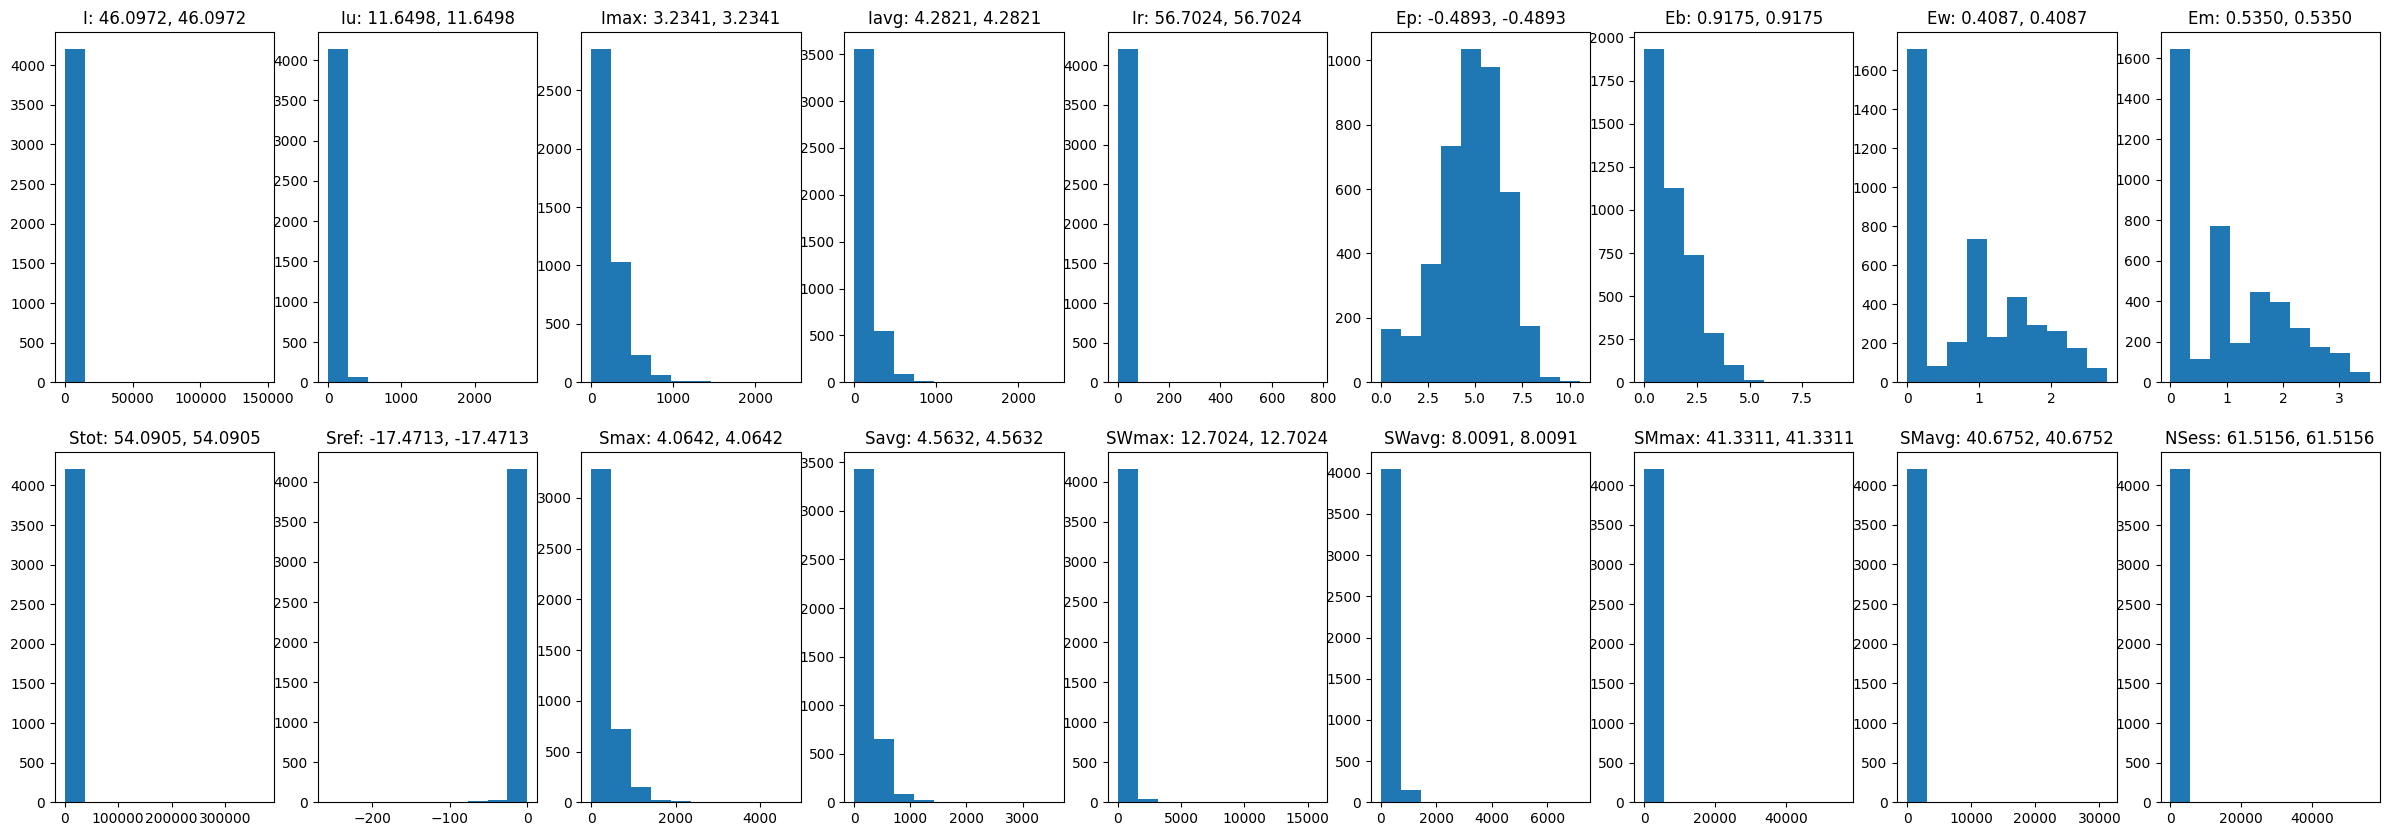

In [249]:
f, axs = plt.subplots(nrows = 2, ncols = 9, figsize=(30,10))
for i in range(len(cs.columns)):
    axs[int(i/9)][i%9].hist(cs[cs.columns[i]])
    axs[int(i/9)][i%9].set_title(cs.columns[i] + ": " + '{:.4f}'.format(cs[cs.columns[i]].skew()) + ", " + '{:.4f}'.format(cs[cs.columns[i]].skew()))
plt.show()

Also, most of the attributes from Customers seems to have a value of Kurtosis greatly over 3. This classify them as leptokurtic and suggests an heavy presence of outliers. 
In order to deal with said outliers we again dedicate a section to improving the data quality of the dataset. The distributions of the attributes from Customers will be displayed after the aforemenioned process.  

### Analysing the Country, Faw_weekday and Fav_month attributes

#### Country
We proceed by displaying the distribution of the customers among the different countries.

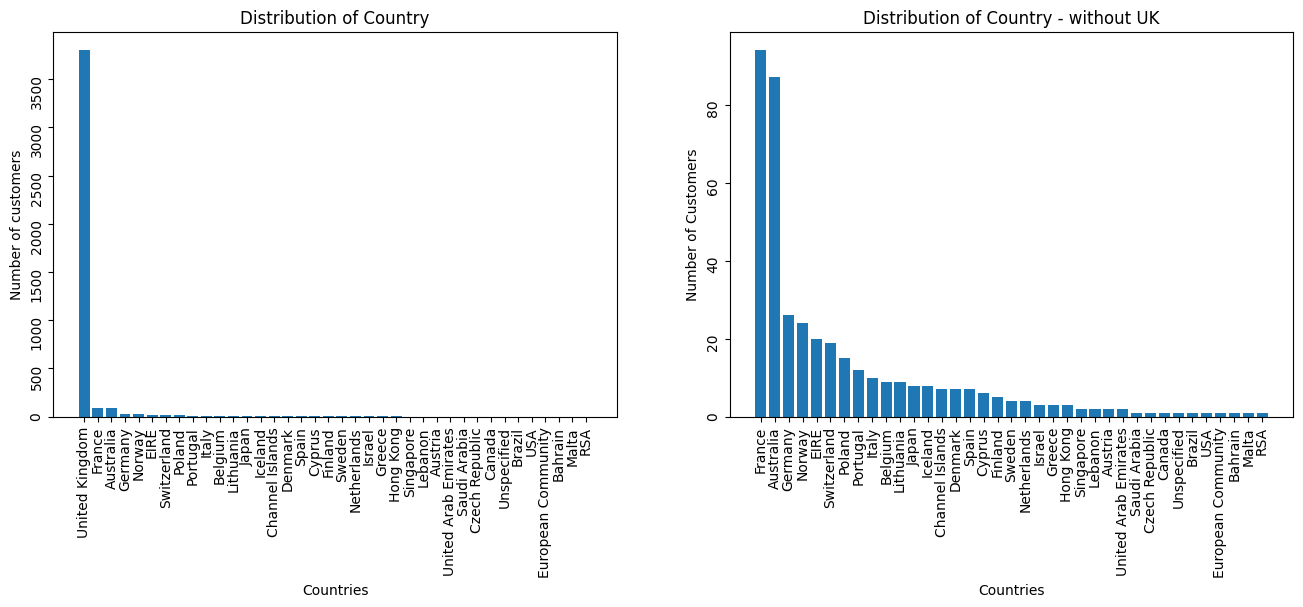

In [250]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(cs_cat.Country.unique(),cs_cat.Country.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Distribution of Country")
axs[0].set_xlabel("Countries")
axs[0].set_ylabel("Number of customers")

axs[1].bar(cs_cat[cs_cat.Country != 'United Kingdom'].Country.unique(), cs_cat[cs_cat.Country != 'United Kingdom'].Country.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Distribution of Country - without UK")
axs[1].set_xlabel("Countries")
axs[1].set_ylabel("Number of Customers")

plt.show() 

#### Fav_weekday
We proceed by displaying the distribution of the values from Fav_weekday.

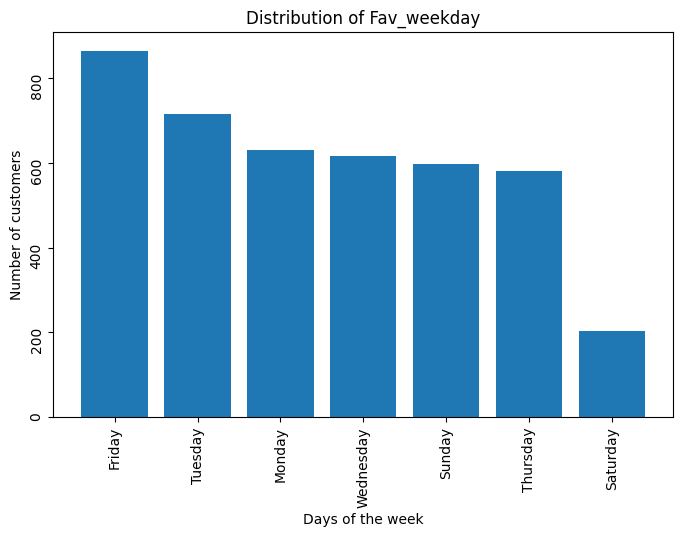

In [251]:
f, axs = plt.subplots(ncols=1, figsize=(8,5))
axs.bar(cs_cat.Fav_weekday.unique(),cs_cat.Fav_weekday.value_counts())
axs.tick_params(labelrotation=90)
axs.set_title("Distribution of Fav_weekday")
axs.set_xlabel("Days of the week")
axs.set_ylabel("Number of customers")

plt.show() 

#### Fav_month
We proceed by displaying the distribution of the values from Fav_month.

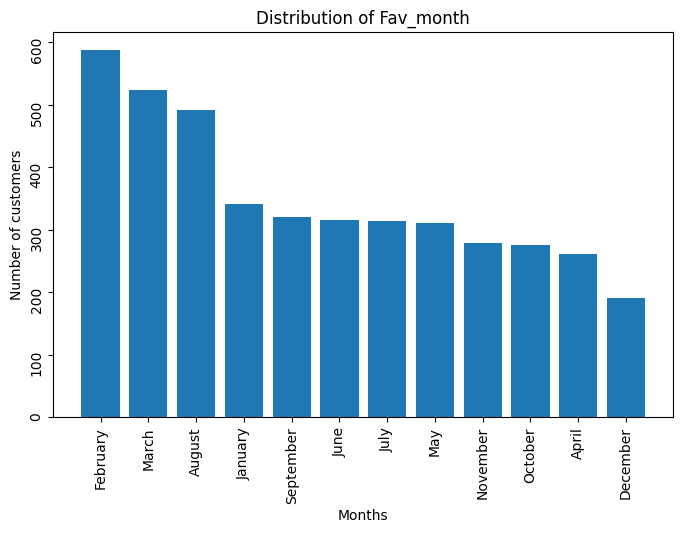

In [252]:
f, axs = plt.subplots(ncols=1, figsize=(8,5))
axs.bar(cs_cat.Fav_month.unique(),cs_cat.Fav_month.value_counts())
axs.tick_params(labelrotation=90)
axs.set_title("Distribution of Fav_month")
axs.set_xlabel("Months")
axs.set_ylabel("Number of customers")

plt.show() 

## Improving the Data Quality of the *Customers* Dataset

### Detecting the outliers of *Customers*

In order to visualize the outliers contained within the dataset, we compute the boxplots associated with each of its attributes.

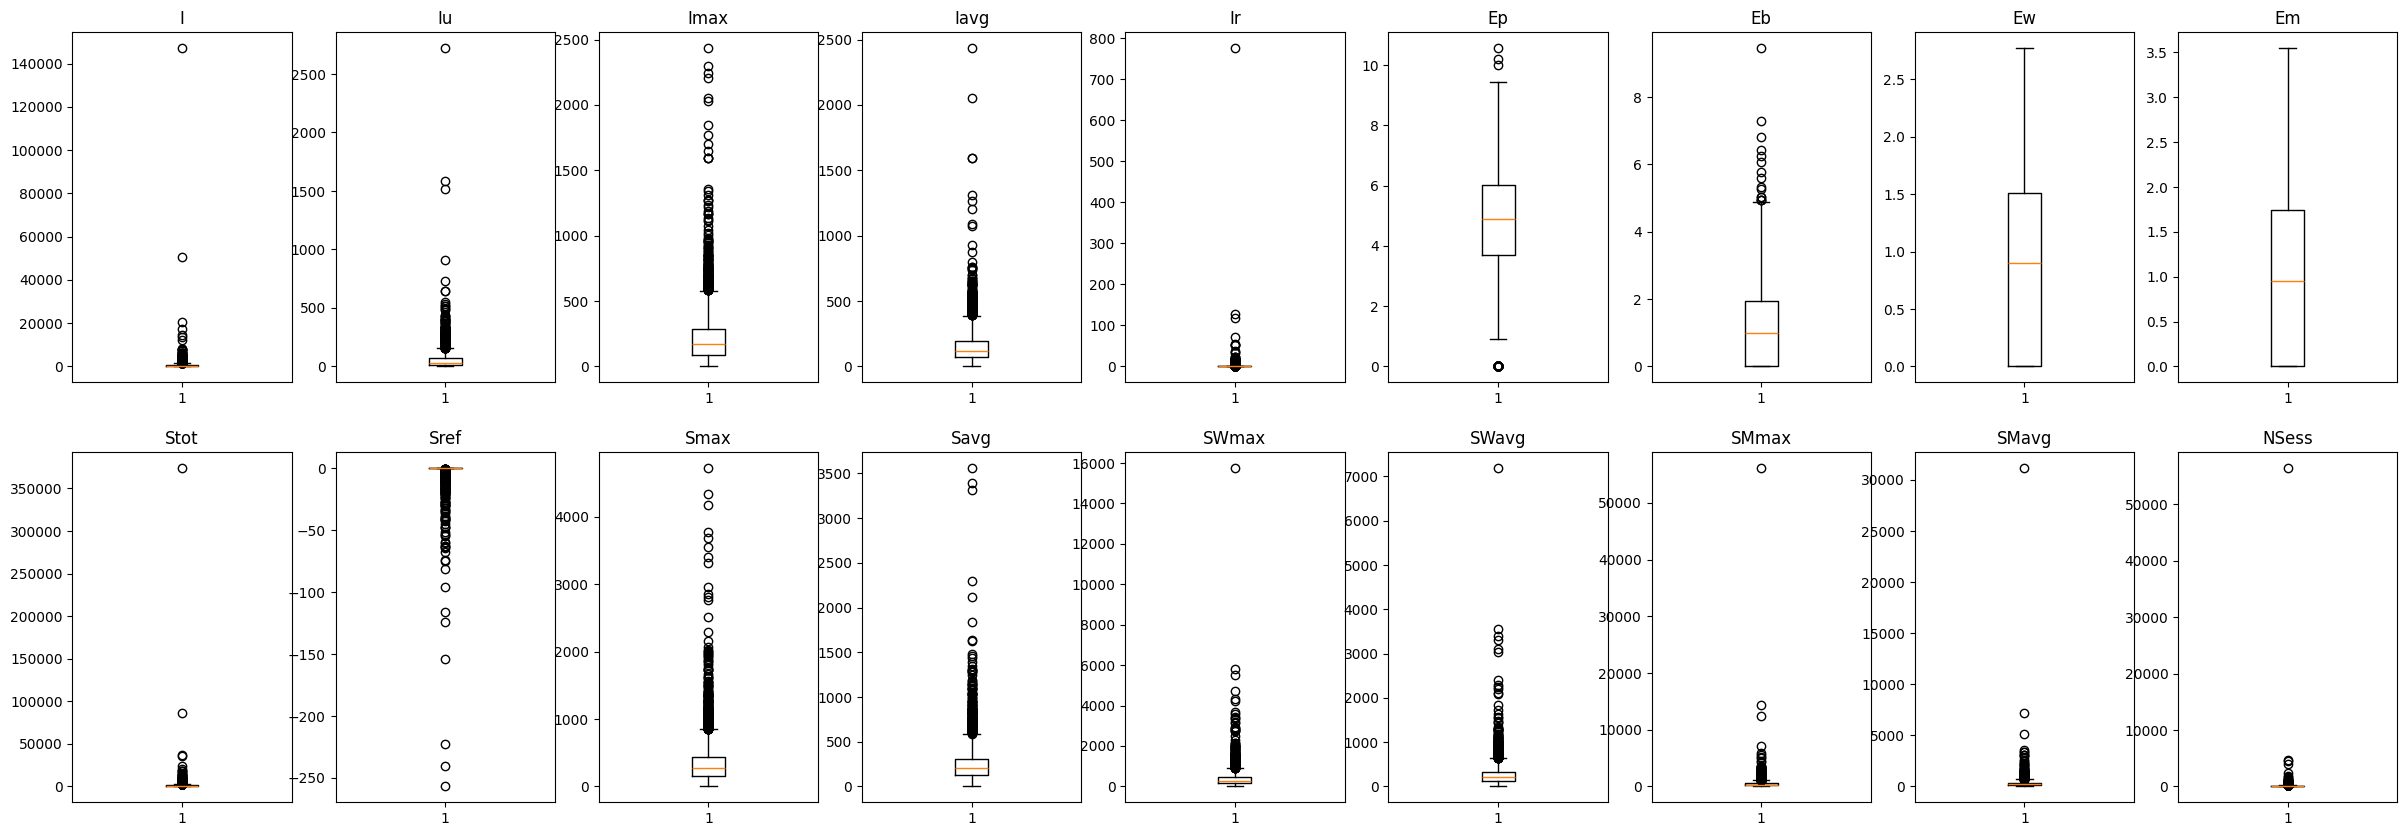

In [253]:
f, axs = plt.subplots(nrows = 2, ncols = 9, figsize=(30,10))
for i in range(len(cs.columns)):
    axs[int(i/9)][i%9].boxplot(cs[cs.columns[i]])
    axs[int(i/9)][i%9].set_title(cs.columns[i])
plt.show()

The populations of I, Iu, Imax, Stot, Smax and NSess do present outliers, we proceed by removing this employing once again the Inter-Quantile Range.

### Handling the outliers of *Customers*

We create a dataframe dedicated to containing outliers from the *Customers* dataset.

In [254]:
# creating dataframe for outliers
cs_outliers = pd.DataFrame(columns=cs.columns, index=cs.index)    
cs_outliers.drop(cs_outliers.index, inplace=True)

We utilize a milder version of IQR previosly implemented to detect the outliers.

In [255]:
def mild_iqr_values(s): 
    q1 = s.quantile(q = 0.25)
    q3 = s.quantile(q = 0.75)
    iqr = q3 - q1
    iqr_left = q1 - 3*iqr
    iqr_right = q3 + 3*iqr
    return iqr_left, iqr_right

In [258]:
for attribute in cs.columns:
    iqr_left, iqr_right = mild_iqr_values(cs[attribute]) # computing left and right for each attribute
    cs_outliers = pd.concat([cs_outliers, cs[(cs[attribute] < iqr_left) | (cs[attribute] > iqr_right)]]) # computing list of outliers

C:\Users\user\AppData\Local\Temp\ipykernel_30388\2386416909.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cs_outliers = pd.concat([cs_outliers, cs[(cs[attribute] < iqr_left) | (cs[attribute] > iqr_right)]]) # computing list of outliers
C:\Users\user\AppData\Local\Temp\ipykernel_30388\2386416909.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cs_outliers = pd.concat([cs_outliers, cs[(cs[attribute] < iqr_left) | (cs[attribute] > iqr_right)]]) # computing list of outliers
C:\Users\user\AppData\Local\Temp\ipykernel_30388\2386416909.py:3: FutureWarn

Here we display the outliers just identified.

In [259]:
cs_outliers

I   Iu Imax   Iavg  Ir   Ep   Eb   Ew   Em     Stot   Sref  \
CustomerID                                                                  
12583.00    3031  103  362 202.07   0 6.36 3.82 2.58 3.00  5267.89   0.00   
15311.00    7987  516  407  87.77   7 8.51 6.24 2.72 3.51 17498.95 -16.05   
17511.00    5277  150  511 188.46  19 6.81 4.73 2.41 3.29 12117.42 -47.25   
13408.00    4193  127  365  80.63   0 6.70 5.27 2.30 3.41  9322.80   0.00   
13767.00    3151   42  173  87.53   0 4.75 5.02 2.51 3.27  7604.21   0.00   
...          ...  ...  ...    ...  ..  ...  ...  ...  ...      ...    ...   
17813.00     671  265  505 134.20   0 7.97 1.51 1.09 1.51  1154.07   0.00   
17509.00    3512   75  500 439.00   0 5.97 2.95 1.16 0.87  6083.64   0.00   
14547.00    2002  181  544 250.25   0 7.29 2.70 1.31 1.67  3315.76   0.00   
15993.00    1900  305  616 316.67   1 8.05 2.41 1.30 1.75  2236.88  -2.95   
13521.00     709  305  299 236.33   0 8.13 1.55 0.99 1.55   978.18   0.00   

             Smax   Savg   SWmax   SWavg   SMmax   SMavg NSess  
CustomerID                                                      
12583.00   737.66 351.19  737.66  405.22 1074.75  585.32   203  
15311.00   908.38 192.30  908.38  364.56 2736.98 1458.25  1890  
17511.00   944.52 432.76 1225.92  504.89 2781.52 1009.78   309  
13408.00   804.79 179.28  804.79  310.76 1230.42  776.90   258  
13767.00   420.70 211.23  768.36  330.62 1237.72  691.29   266  
...           ...    ...     ...     ...     ...     ...   ...  
17813.00   727.93 230.81  727.93  230.81  727.93  230.81   309  
17509.00   898.14 760.46 4302.36 3041.82 4302.36 3041.82   364  
14547.00   921.28 414.47  921.28  552.63 2070.50  828.94   317  
15993.00   756.27 372.81 1048.19  447.38 1048.19  559.22   503  
13521.00   357.55 326.06  357.55  326.06  357.55  326.06   409  

[3348 rows x 18 columns]

We now drop the duplicated rows within the outliers dataset. 

Such process is necessary to deal with the redundancy fueled by the process detecting outliers for one attribute at a time. A record judged as outlier for a first column could be selected again during the turn of one, or more, of the following ones.

In [260]:
# dropping redundant outliers
cs_outliers.drop_duplicates(inplace=True)
cs_outliers

I   Iu Imax   Iavg  Ir   Ep   Eb   Ew   Em     Stot   Sref  \
CustomerID                                                                  
12583.00    3031  103  362 202.07   0 6.36 3.82 2.58 3.00  5267.89   0.00   
15311.00    7987  516  407  87.77   7 8.51 6.24 2.72 3.51 17498.95 -16.05   
17511.00    5277  150  511 188.46  19 6.81 4.73 2.41 3.29 12117.42 -47.25   
13408.00    4193  127  365  80.63   0 6.70 5.27 2.30 3.41  9322.80   0.00   
13767.00    3151   42  173  87.53   0 4.75 5.02 2.51 3.27  7604.21   0.00   
...          ...  ...  ...    ...  ..  ...  ...  ...  ...      ...    ...   
16813.00    1118  237  181 111.80   0 7.61 3.18 1.44 2.83  1385.57   0.00   
14178.00    1299  181  318 185.57   0 7.27 2.72 2.21 2.49  1446.49   0.00   
18122.00    1043  225  297 173.83   0 7.56 2.43 2.20 2.43  1609.62   0.00   
16474.00     891  229  225 148.50   0 7.68 2.27 1.75 2.03  1674.65   0.00   
16764.00    1222  195  138  94.00   0 7.26 3.65 2.19 2.74  2530.57   0.00   

             Smax   Savg   SWmax  SWavg   SMmax   SMavg NSess  
CustomerID                                                     
12583.00   737.66 351.19  737.66 405.22 1074.75  585.32   203  
15311.00   908.38 192.30  908.38 364.56 2736.98 1458.25  1890  
17511.00   944.52 432.76 1225.92 504.89 2781.52 1009.78   309  
13408.00   804.79 179.28  804.79 310.76 1230.42  776.90   258  
13767.00   420.70 211.23  768.36 330.62 1237.72  691.29   266  
...           ...    ...     ...    ...     ...     ...   ...  
16813.00   191.11 138.56  191.11 138.56  330.79  173.20   407  
14178.00   320.10 206.64  320.10 206.64  410.87  241.08   305  
18122.00   394.54 268.27  394.54 268.27  394.54  268.27   342  
16474.00   483.15 279.11  483.15 279.11  483.15  334.93   324  
16764.00   316.14 194.66  316.14 194.66  633.13  316.32   674  

[566 rows x 18 columns]

We now drop the remaining distinct outliers from the numerical and categorical dataframes for *Customers*.

In [261]:
# dropping outliers
cs.drop(cs_outliers.index, inplace=True)
cs_cat.drop(cs_outliers.index, inplace=True)

## Data Distributions of the Customers Dataset

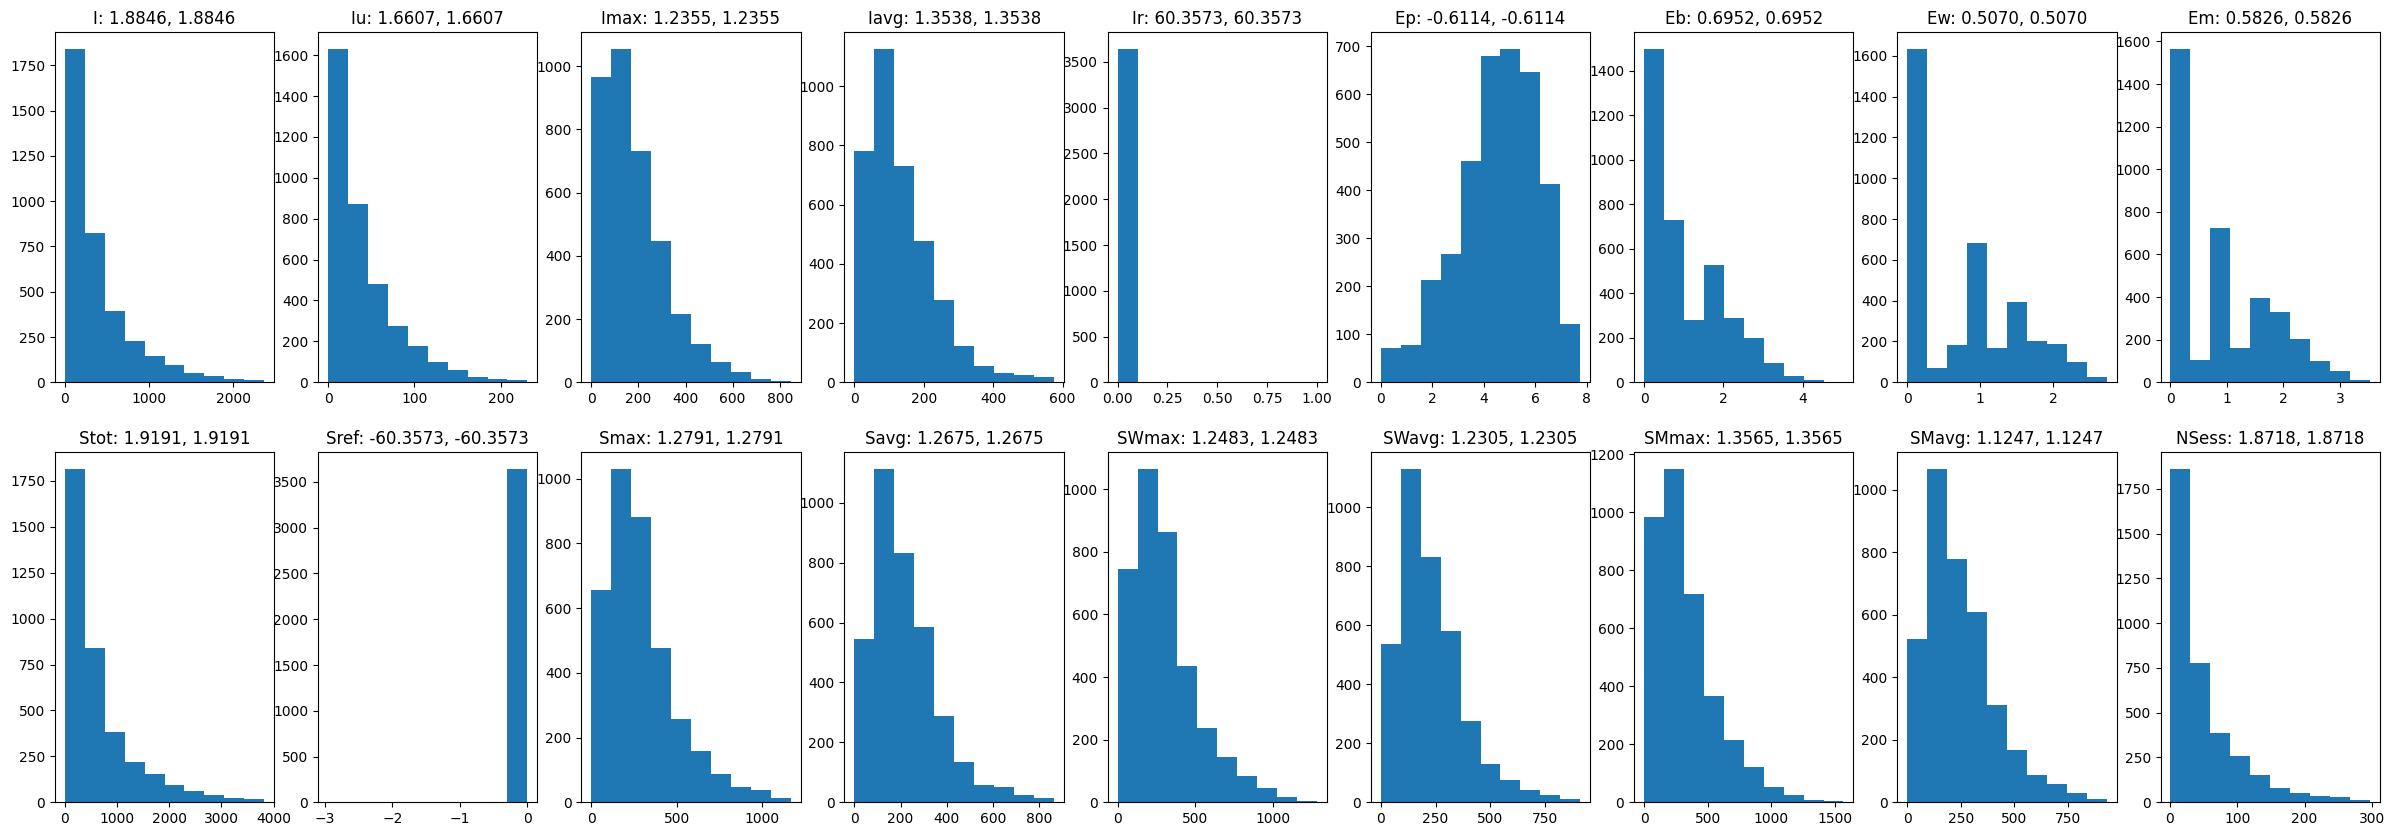

In [262]:
f, axs = plt.subplots(nrows = 2, ncols = 9, figsize=(30,10))
for i in range(len(cs.columns)):
    axs[int(i/9)][i%9].hist(cs[cs.columns[i]])
    axs[int(i/9)][i%9].set_title(cs.columns[i] + ": " + '{:.4f}'.format(cs[cs.columns[i]].skew()) + ", " + '{:.4f}'.format(cs[cs.columns[i]].skew()))
plt.show()

The distributions of both Ir and Sref suggest a severe lack of variance in their population. We are now going to investigate this assumption. 

In [263]:
cs.Ir.describe()

count   3643.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Ir, dtype: float64

In [264]:
cs.Ir.value_counts()

Ir
0    3642
1       1
Name: count, dtype: int64

In [265]:
cs.Sref.describe()

count   3643.00
mean      -0.00
std        0.05
min       -2.95
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Sref, dtype: float64

In [266]:
cs.Sref.value_counts()

Sref
0.00     3642
-2.95       1
Name: count, dtype: int64

The process of eliminating the outliers from within the dataset seems to have eliminated most of the non-zero population of the two attributes. As such, their relevance in the following analysis results greatly diminished. 

## Correlations among the Attributes of Customers

We now compute the correlation matrix related to the numerical attributes of the *Customers* dataset.

In [267]:
mat = cs.corr()

The matrix above can be also used as a parameter for the seaborn function **heatmap()**. This will plot a matrix where the color of the cell corresponds to the intensity of the correlation among the attributes. 

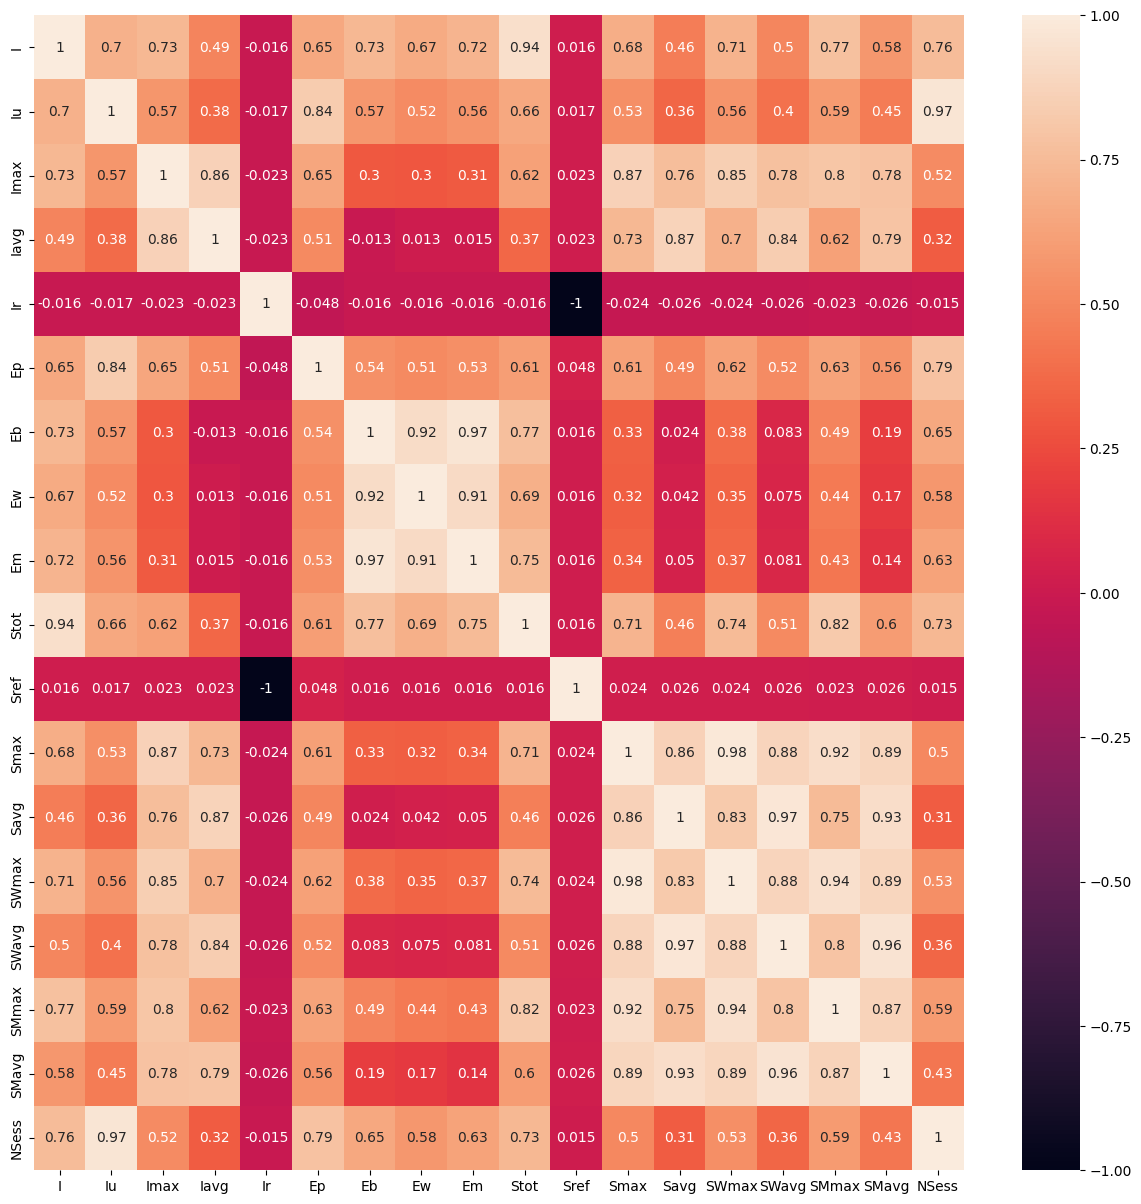

In [268]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(mat, annot=True)
plt.show()

We proceed by discussing some of the highest correlations among the attributes of the dataset:
- the high correlations between **I** and **Stot**, and **Imax** and **Smax**, refer to the increase in cost being obviously proportional to the number of products bought

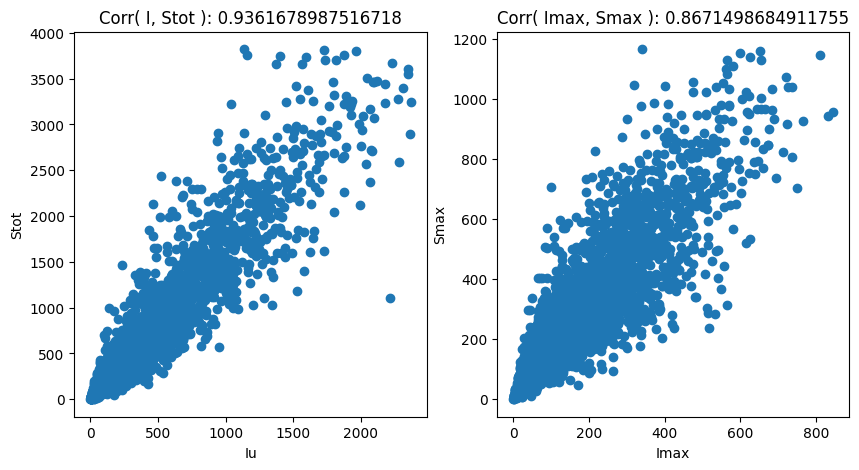

In [269]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
axs[0].scatter(cs.I, cs.Stot)
axs[0].set_title('Corr( I, Stot ): ' + str(cs.I.corr(cs.Stot)))
axs[0].set_xlabel('Iu')
axs[0].set_ylabel('Stot')
axs[1].scatter(cs.Imax, cs.Smax)
axs[1].set_title('Corr( Imax, Smax ): ' + str(cs.Imax.corr(cs.Smax)))
axs[1].set_xlabel('Imax')
axs[1].set_ylabel('Smax')
plt.show()

- the correlation between **Iu** and **Ep** is expected due to both attributes being an indicator of variety (and disorder) within the customer's choice of products

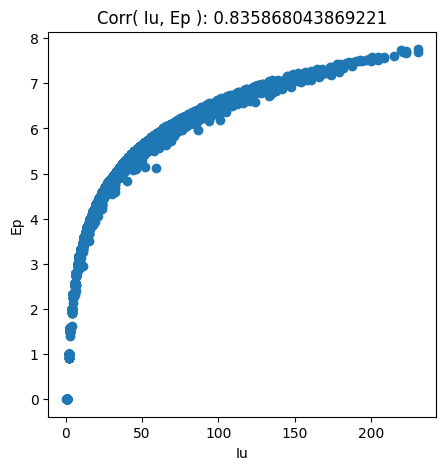

In [270]:
f, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))
axs.scatter(cs.Iu, cs.Ep)
axs.set_title('Corr( Iu, Ep ): ' + str(cs.Iu.corr(cs.Ep)))
axs.set_xlabel('Iu')
axs.set_ylabel('Ep')
plt.show()

- the very high correlation between **Iu** and **NSess**, as the one between **Ep** and **NSess**, highlights a type of non-routine spending, new sessions often lead to the purchase of new types of products

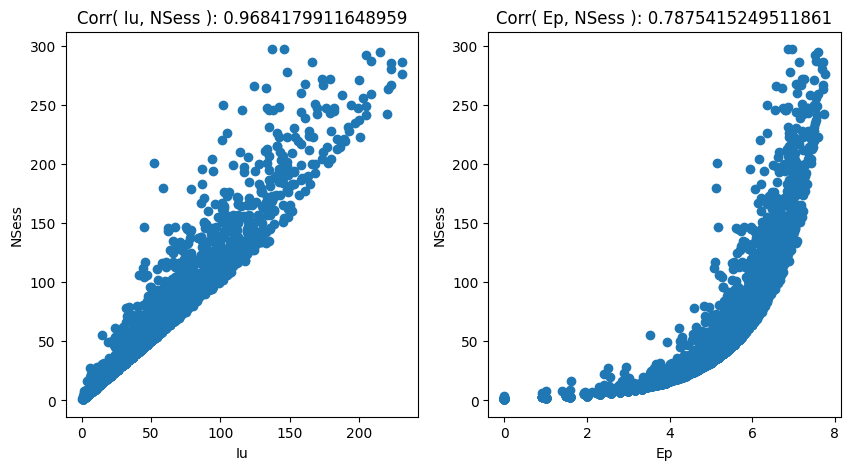

In [271]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
axs[0].scatter(cs.Iu, cs.NSess)
axs[0].set_title('Corr( Iu, NSess ): ' + str(cs.Iu.corr(cs.NSess)))
axs[0].set_xlabel('Iu')
axs[0].set_ylabel('NSess')
axs[1].scatter(cs.Ep, cs.NSess)
axs[1].set_title('Corr( Ep, NSess ): ' + str(cs.Ep.corr(cs.NSess)))
axs[1].set_xlabel('Ep')
axs[1].set_ylabel('NSess')
plt.show()

- the high correlations between the attributes **Eb**, **Ew** and **Em** is expected due to their very similar nature  

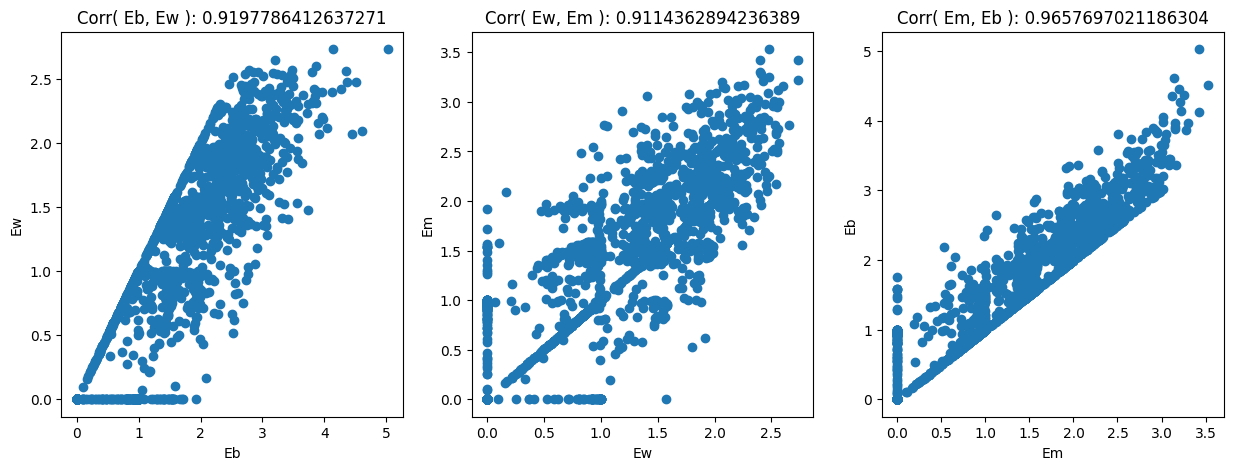

In [272]:
f, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))
axs[0].scatter(cs.Eb, cs.Ew)
axs[0].set_title('Corr( Eb, Ew ): ' + str(cs.Eb.corr(cs.Ew)))
axs[0].set_xlabel('Eb')
axs[0].set_ylabel('Ew')
axs[1].scatter(cs.Ew, cs.Em)
axs[1].set_title('Corr( Ew, Em ): ' + str(cs.Ew.corr(cs.Em)))
axs[1].set_xlabel('Ew')
axs[1].set_ylabel('Em')
axs[2].scatter(cs.Em, cs.Eb)
axs[2].set_title('Corr( Em, Eb ): ' + str(cs.Em.corr(cs.Eb)))
axs[2].set_xlabel('Em')
axs[2].set_ylabel('Eb')
plt.show()

- **Smax**, **SWmax** and **SMmax**, just like **Savg**, **SWavg** and **SMavg**, all aim to measure the same kind of information while considering a specific frame of the whole period of observation, their very high correlation is not surprising

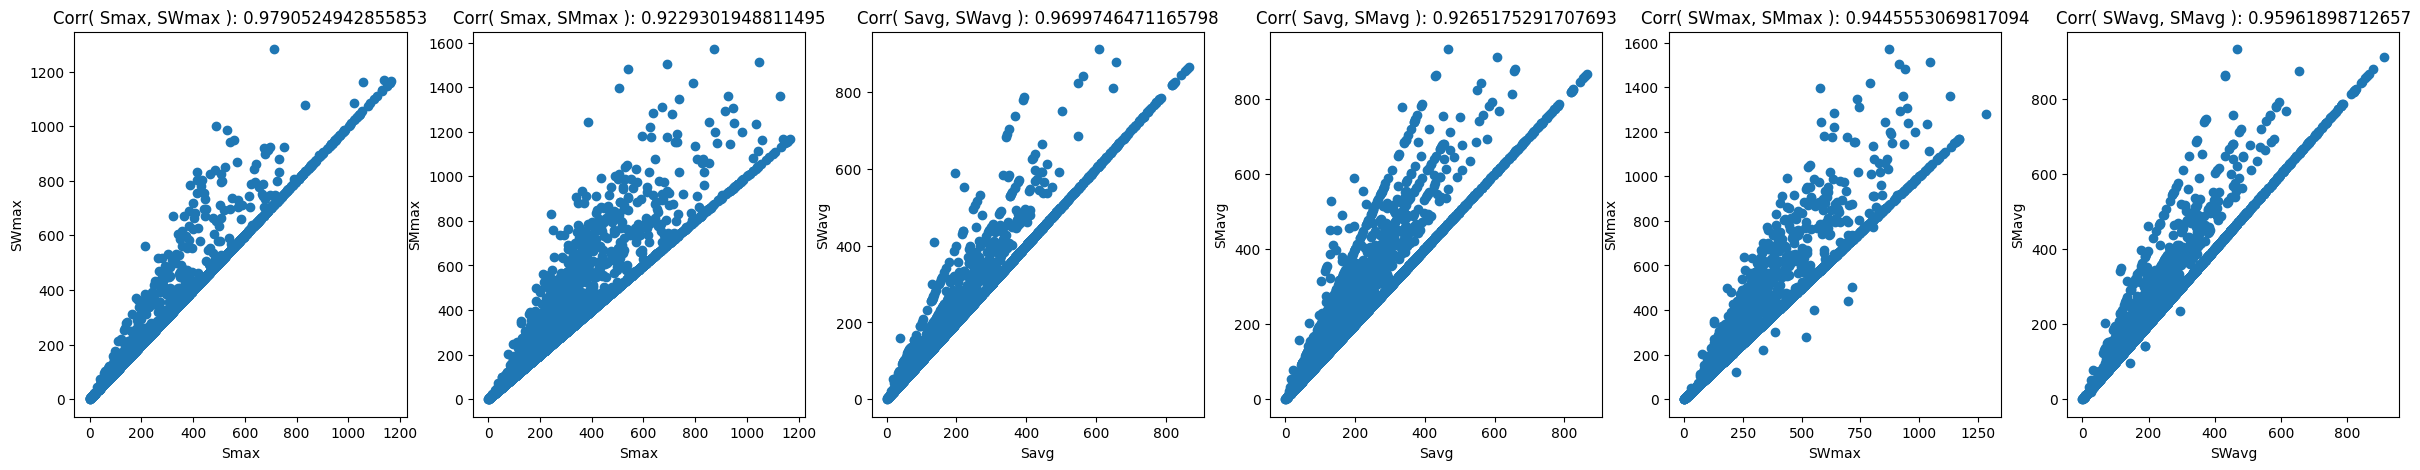

In [273]:
f, axs = plt.subplots(nrows = 1, ncols = 6, figsize=(30,5))
axs[0].scatter(cs.Smax, cs.SWmax)
axs[0].set_title('Corr( Smax, SWmax ): ' + str(cs.Smax.corr(cs.SWmax)))
axs[0].set_xlabel('Smax')
axs[0].set_ylabel('SWmax')
axs[1].scatter(cs.Smax, cs.SMmax)
axs[1].set_title('Corr( Smax, SMmax ): ' + str(cs.Smax.corr(cs.SMmax)))
axs[1].set_xlabel('Smax')
axs[1].set_ylabel('SMmax')
axs[2].scatter(cs.Savg, cs.SWavg)
axs[2].set_title('Corr( Savg, SWavg ): ' + str(cs.Savg.corr(cs.SWavg)))
axs[2].set_xlabel('Savg')
axs[2].set_ylabel('SWavg')
axs[3].scatter(cs.Savg, cs.SMavg)
axs[3].set_title('Corr( Savg, SMavg ): ' + str(cs.Savg.corr(cs.SMavg)))
axs[3].set_xlabel('Savg')
axs[3].set_ylabel('SMavg')
axs[4].scatter(cs.SWmax, cs.SMmax)
axs[4].set_title('Corr( SWmax, SMmax ): ' + str(cs.SWmax.corr(cs.SMmax)))
axs[4].set_xlabel('SWmax')
axs[4].set_ylabel('SMmax')
axs[5].scatter(cs.SWavg, cs.SMavg)
axs[5].set_title('Corr( SWavg, SMavg ): ' + str(cs.SWavg.corr(cs.SMavg)))
axs[5].set_xlabel('SWavg')
axs[5].set_ylabel('SMavg')
plt.show()

## Extra: Storing the datasets in csv files

In order to make use of the dataset created within the other steps of this analysis, we extract it in the form of a csv file.

Furthermore, in order to reduce the dimensionality of the dataset, also given the sensitivity of activities such as clustering to the presence of too much correlated attributes, we decide to drop some of the attributes discussed within the **Correlations among the Attributes of Customers** section.

In [274]:
cs_num = cs
cs_num.drop(columns=['Ir', 'Ew', 'Em', 'Sref', 'SWmax', 'SWavg', 'SMmax', 'SMavg'], inplace=True)

This is the set of categorical attributes to be extracted.

In [275]:
cs_cat

Country Fav_weekday  Fav_month
CustomerID                                       
13047.00    United Kingdom      Friday      March
14688.00    United Kingdom     Tuesday   February
17809.00    United Kingdom      Friday      March
16098.00    United Kingdom     Tuesday  September
18074.00    United Kingdom     Tuesday    January
...                    ...         ...        ...
13436.00    United Kingdom      Friday     August
15520.00    United Kingdom      Friday     August
13298.00    United Kingdom      Friday     August
14569.00    United Kingdom      Friday     August
12713.00           Germany      Monday  September

[3643 rows x 3 columns]

The two sets are exported separately being them usually involved in different phases of the subsequent analysis, i.e. the clustering of the dataset and the characterization of the clusters obtained.

We now proceed with the creation of the two csv files.

In [276]:
cs_num.to_csv(path_or_buf='dataset/customers_num.csv')
cs_cat.to_csv(path_or_buf='dataset/customers_cat.csv')